# COVID-19 data exploration and monitoring
With credits to Saeed Amen at Cuemacro (www.cuemacro.com)

With inspiration from Saeed, this notebook intends to explore and visualise the trends of case growth in COVID-19 cases. In particular, I hope to understand more about the density of the infections relative to the population of a particular area.

Currently, the sources for this notebook come from the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) repository at https://github.com/CSSEGISandData/COVID-19, the source for the data in [another dashboard](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

This repository contains data in multiple forms. As of the time of writing, there are WHO situation reports as well as data from the CSSE COVID-19 dataset. In each of these datasets, there are daily snapshot reports, as well as the time series of each of the datasets. Lastly, there is a directory containing archived data. The CSSE COVID-19 dataset also includes a look-up table for ISO FIPS UID.

In [1]:
REPO_PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
CSSE_DATA_PATH = REPO_PATH + "csse_covid_19_data/"
TIME_SERIES_PATH = CSSE_DATA_PATH + "csse_covid_19_time_series/"

In [2]:
CSV_URL = {}
CSV_URL['CONFIRMED'] = "time_series_covid19_confirmed_global.csv"
CSV_URL['DEATHS'] = "time_series_covid19_deaths_global.csv"
CSV_URL['RECOVERED'] = "time_series_covid19_recovered_global.csv"
CSV_URL['US_CONFIRMED'] = "time_series_covid19_confirmed_US.csv"
CSV_URL['US_DEATHS'] = "time_series_covid19_deaths_US.csv"

In [178]:
# download OECD information
OECD_CSV = "https://stats.oecd.org/sdmx-json/data/DP_LIVE/.POP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en"

# World Bank population data
WORLDBANK_API_URL = "http://api.worldbank.org/v2/en/indicator/"
WORLDBANK_API_CSV = "?downloadformat=csv"

def _worldbank_url(wb_code):
    return WORLDBANK_API_URL + wb_code + WORLDBANK_API_CSV

WORLDBANK_POP_CODE = "SP.POP.TOTL"
WORLDBANK_POP_ZIP = _worldbank_url(WORLDBANK_POP_CODE)
WORLDBANK_URBPOP_CODE = "SP.URB.TOTL.IN.ZS"
WORLDBANK_URB_POP_ZIP = _worldbank_url(WORLDBANK_URBPOP_CODE)

In [4]:
import cufflinks as cf
import datetime as dt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile as zf
import csv
import difflib
import io
import itertools
import os
import requests

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
#print(f"Zipfile version: {zf.__version__}")

%matplotlib inline

Numpy version: 1.18.4
Pandas version: 1.0.3


In [5]:
# check renderer for plotly
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

## Confirmed cases

Research questions to be addressed:
1. Has the pace of infections slowed in the US and other (selected) countries?
    * Look at the rate of new cases
        * Does it have a natural tailing off just numerically though? If so, probably related to the below point?
2. Is there a "natural" proportion of the population which will be infected before it tails off?
    * Examine the population in each area, and 
3. How can I identify "regimes" of infection transmission?

In [6]:
df_us_confirmed = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_CONFIRMED'])
                   .rename(columns={'Long_': 'Long',
                                    'Country_Region': 'Country/Region',
                                    'Province_State': 'Province/State'
                                   })
                  )
df_confirmed = pd.read_csv(TIME_SERIES_PATH + CSV_URL['CONFIRMED'])

In [7]:
set(df_us_confirmed.columns) - set(df_confirmed.columns)

{'Admin2', 'Combined_Key', 'FIPS', 'UID', 'code3', 'iso2', 'iso3'}

In [8]:
set(df_confirmed.columns) - set(df_us_confirmed.columns)

set()

In [9]:
def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            try:
                return dt.datetime.strptime(col_name, '%m/%d/%Y').date()
            except ValueError:
                return col_name

In [10]:
df_by_country = (pd.pivot_table(df_confirmed.drop(columns=['Lat', 'Long', 'Province/State']),
                                index=['Country/Region'],
                                aggfunc=np.sum
                               )
                 .rename(columns=_process_columns)
                 .transpose()
                 .sort_index()
                )

## Global

In [11]:
def cases_and_rate(series):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300) 
    ax_2 = ax.twinx()
    ax.set_ylabel('Number of cases')
    ax_2.set_ylabel('pct_change')
    ax.plot(series)
    ax_2.plot(series.pct_change(),
              color='tab:red'
             )
    plt.show()

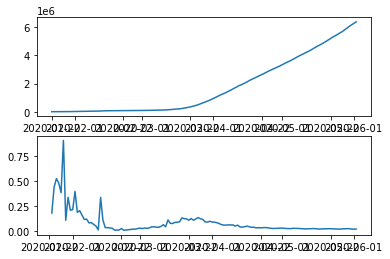

In [12]:
GL_fig, GL_axs = plt.subplots(2)
GL_axs[0].plot(df_by_country.sum(axis=1))
GL_axs[1].plot(df_by_country.sum(axis=1).pct_change())

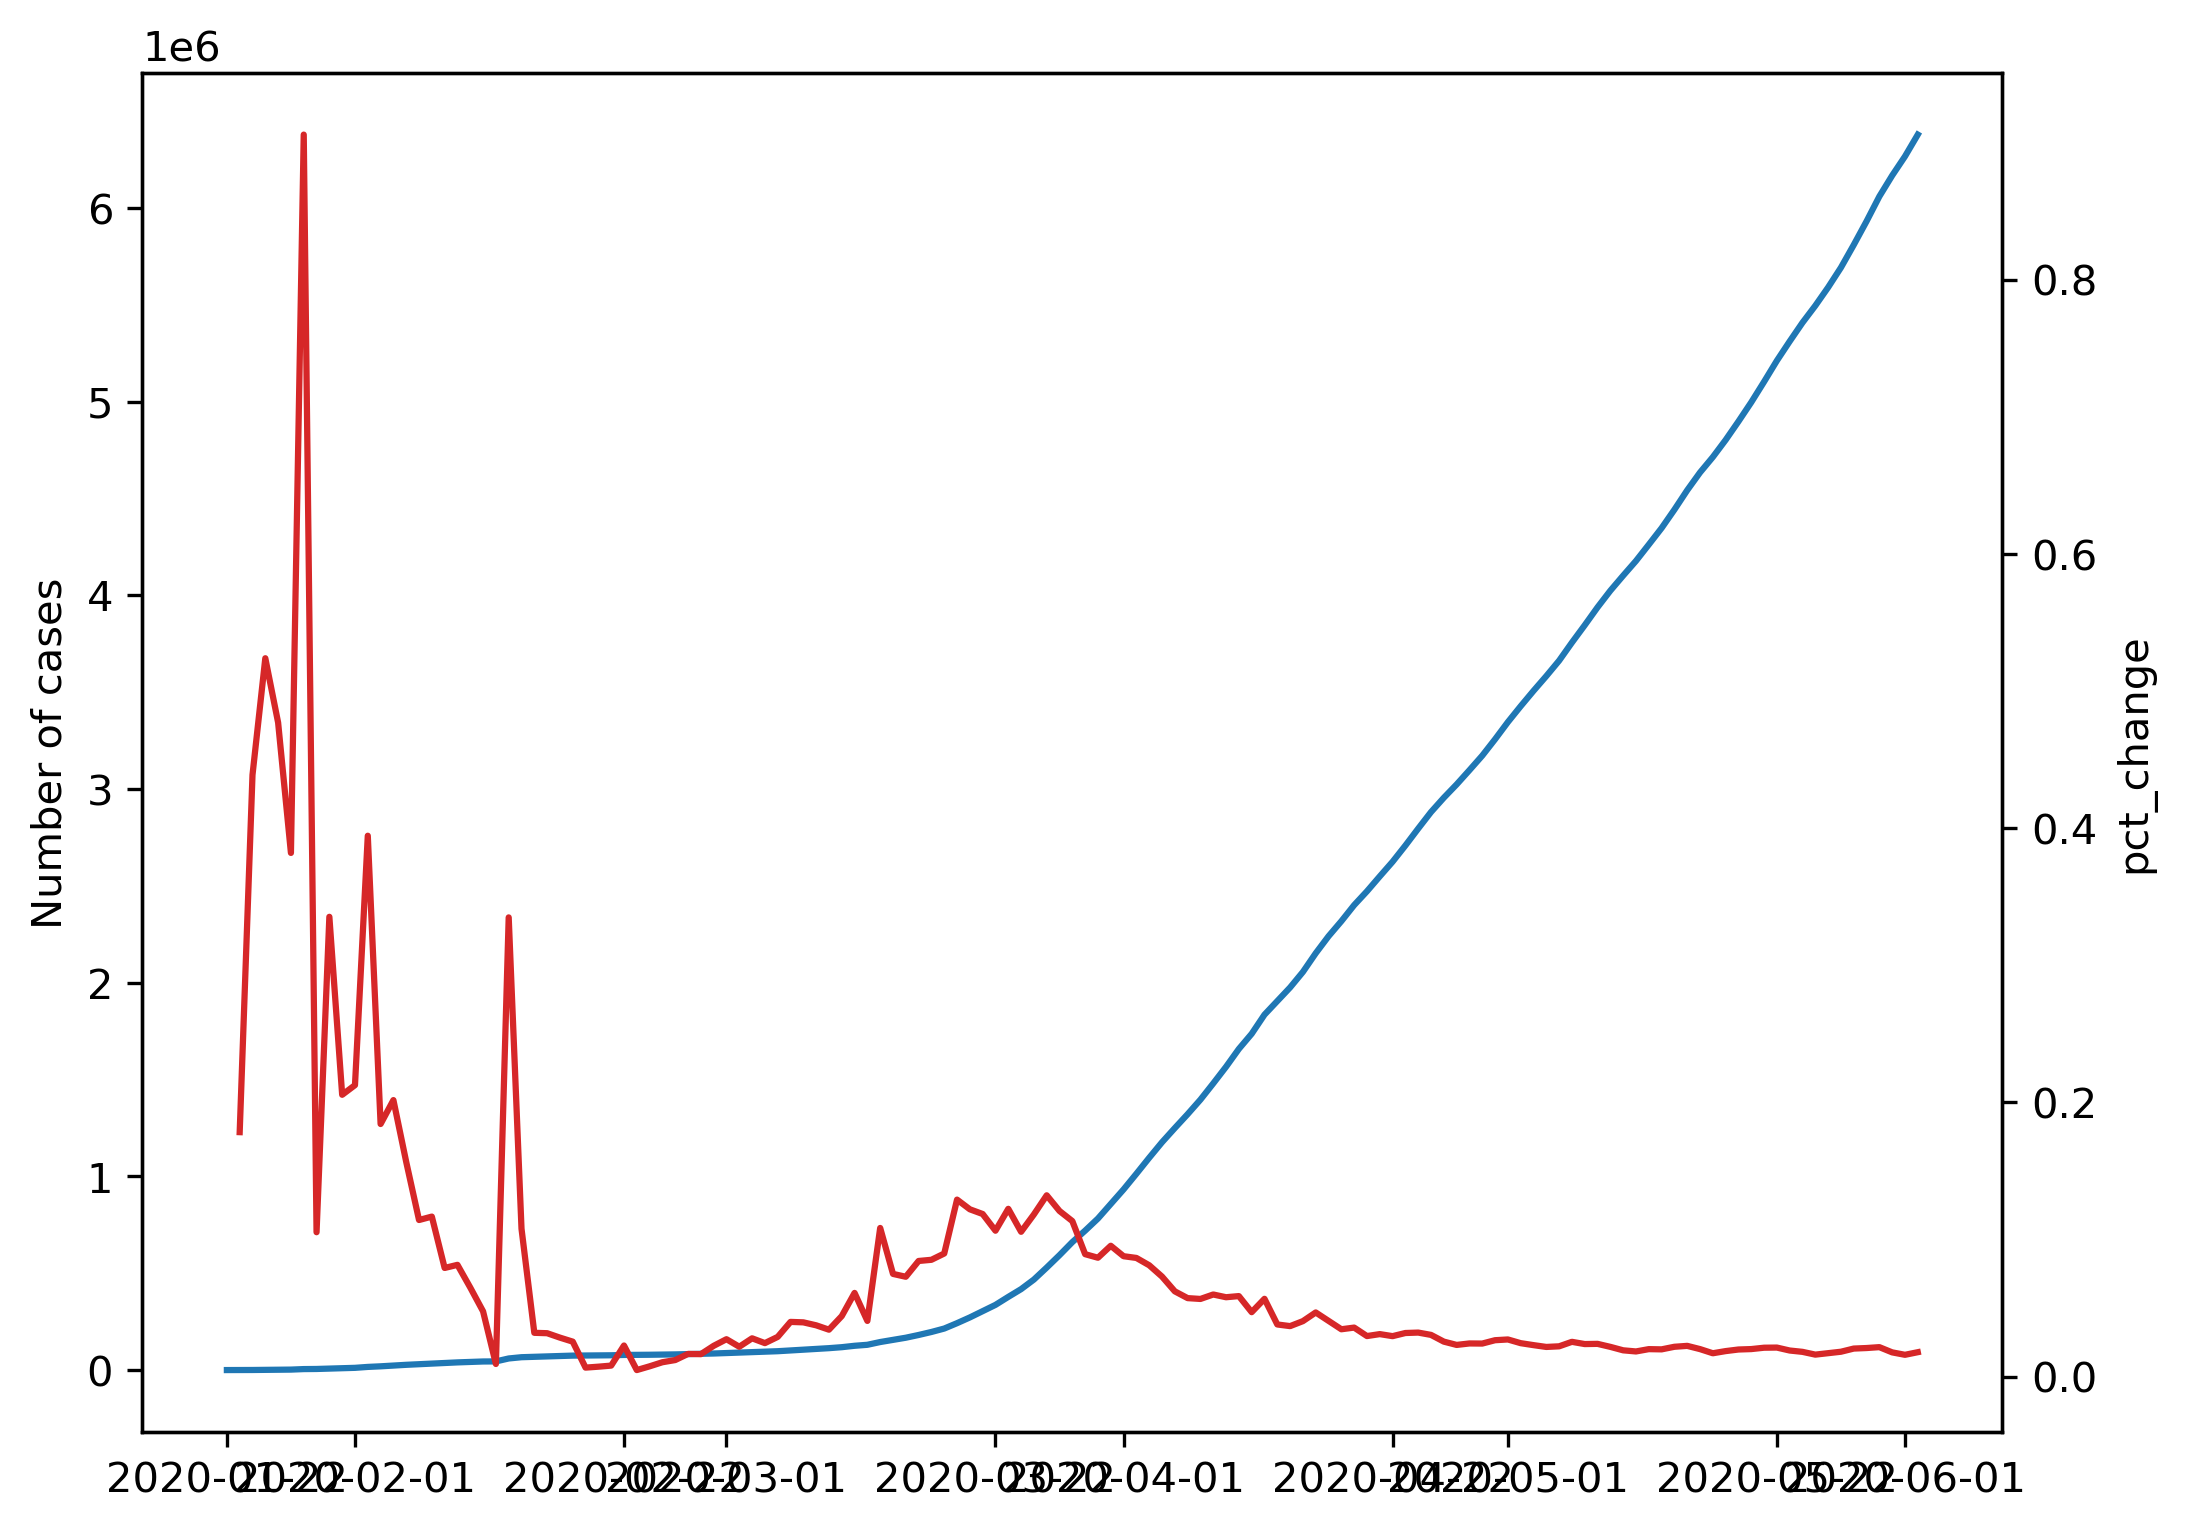

In [13]:
cases_and_rate(df_by_country.sum(axis=1))

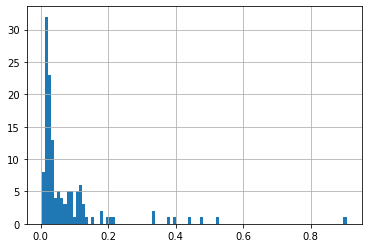

In [14]:
df_by_country.sum(axis=1).pct_change().hist(bins=100)

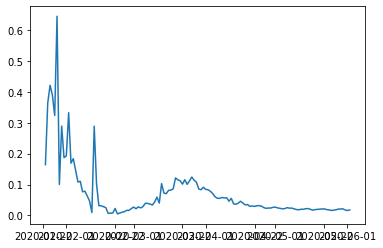

In [15]:
np.log(df_by_country.sum(axis=1)).diff().plot()

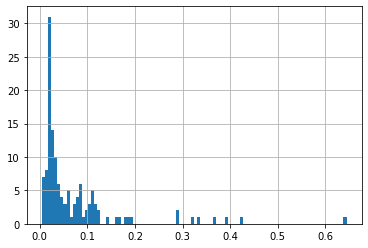

In [16]:
np.log(df_by_country.sum(axis=1)).diff().hist(bins=100)

## United Kingdom

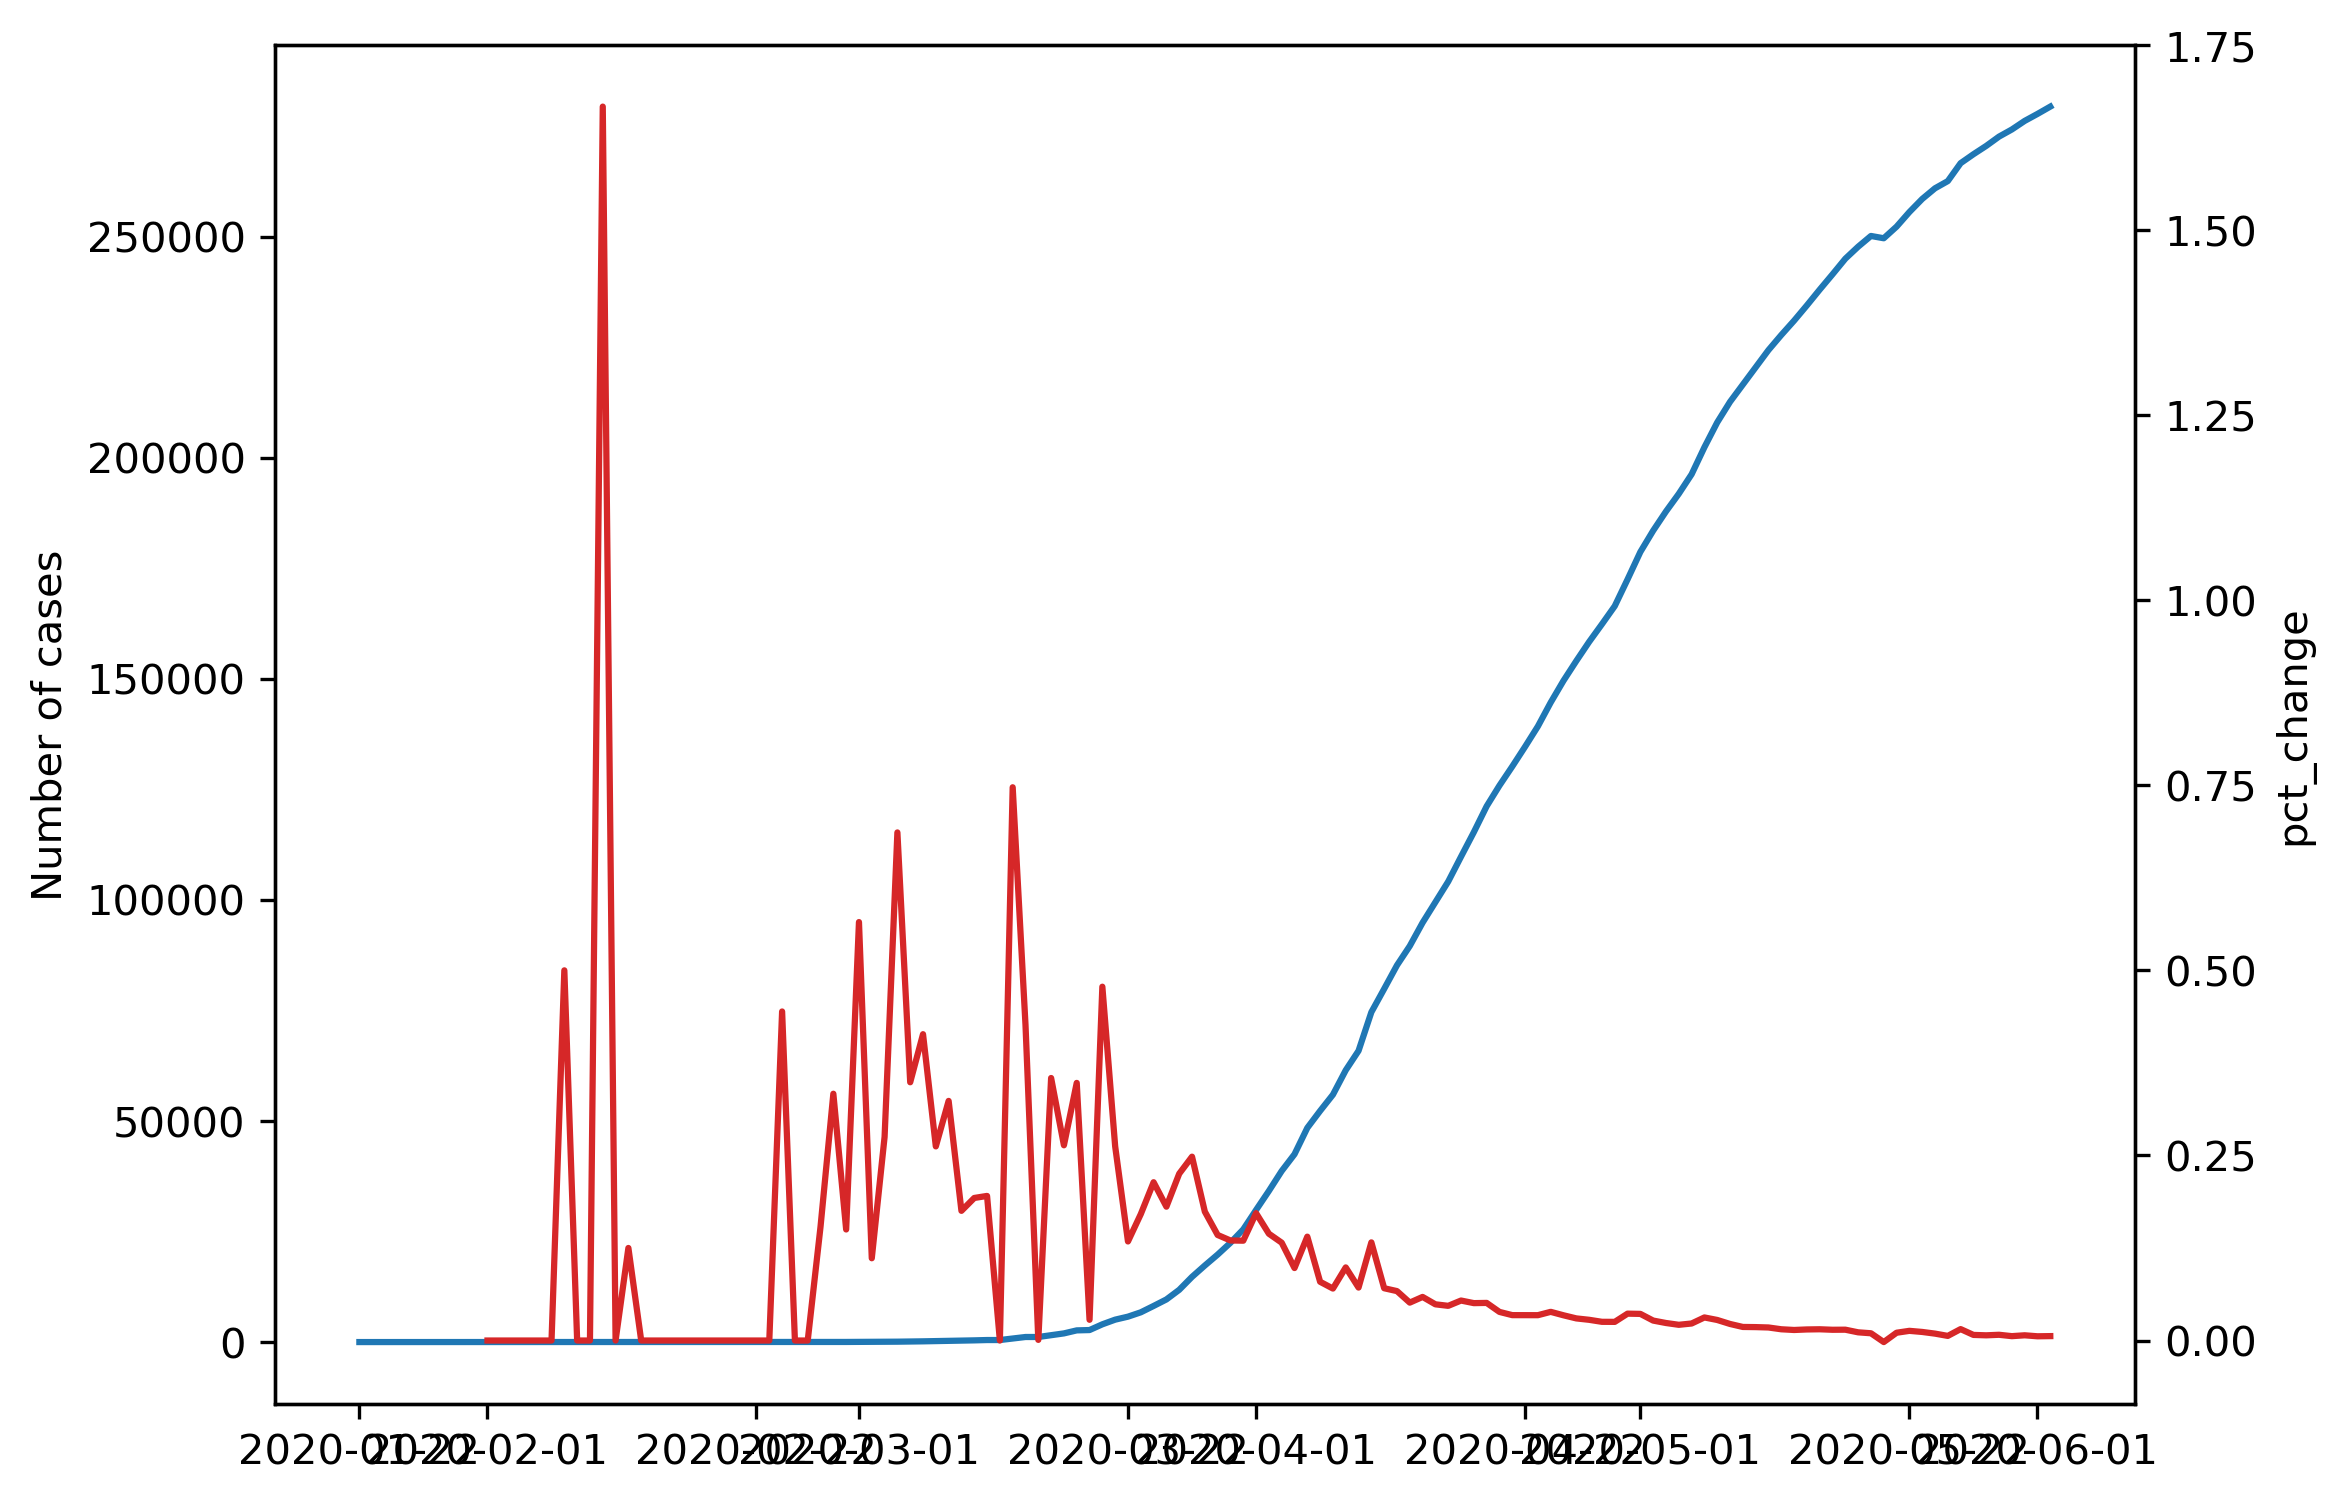

In [17]:
cases_and_rate(df_by_country['United Kingdom'])

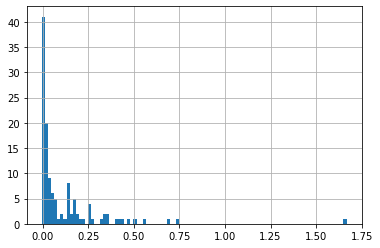

In [18]:
(df_by_country['United Kingdom'].pct_change()
 .replace([np.inf, -np.inf], np.nan)
 .dropna()
 .hist(bins=100)
)

## Singapore

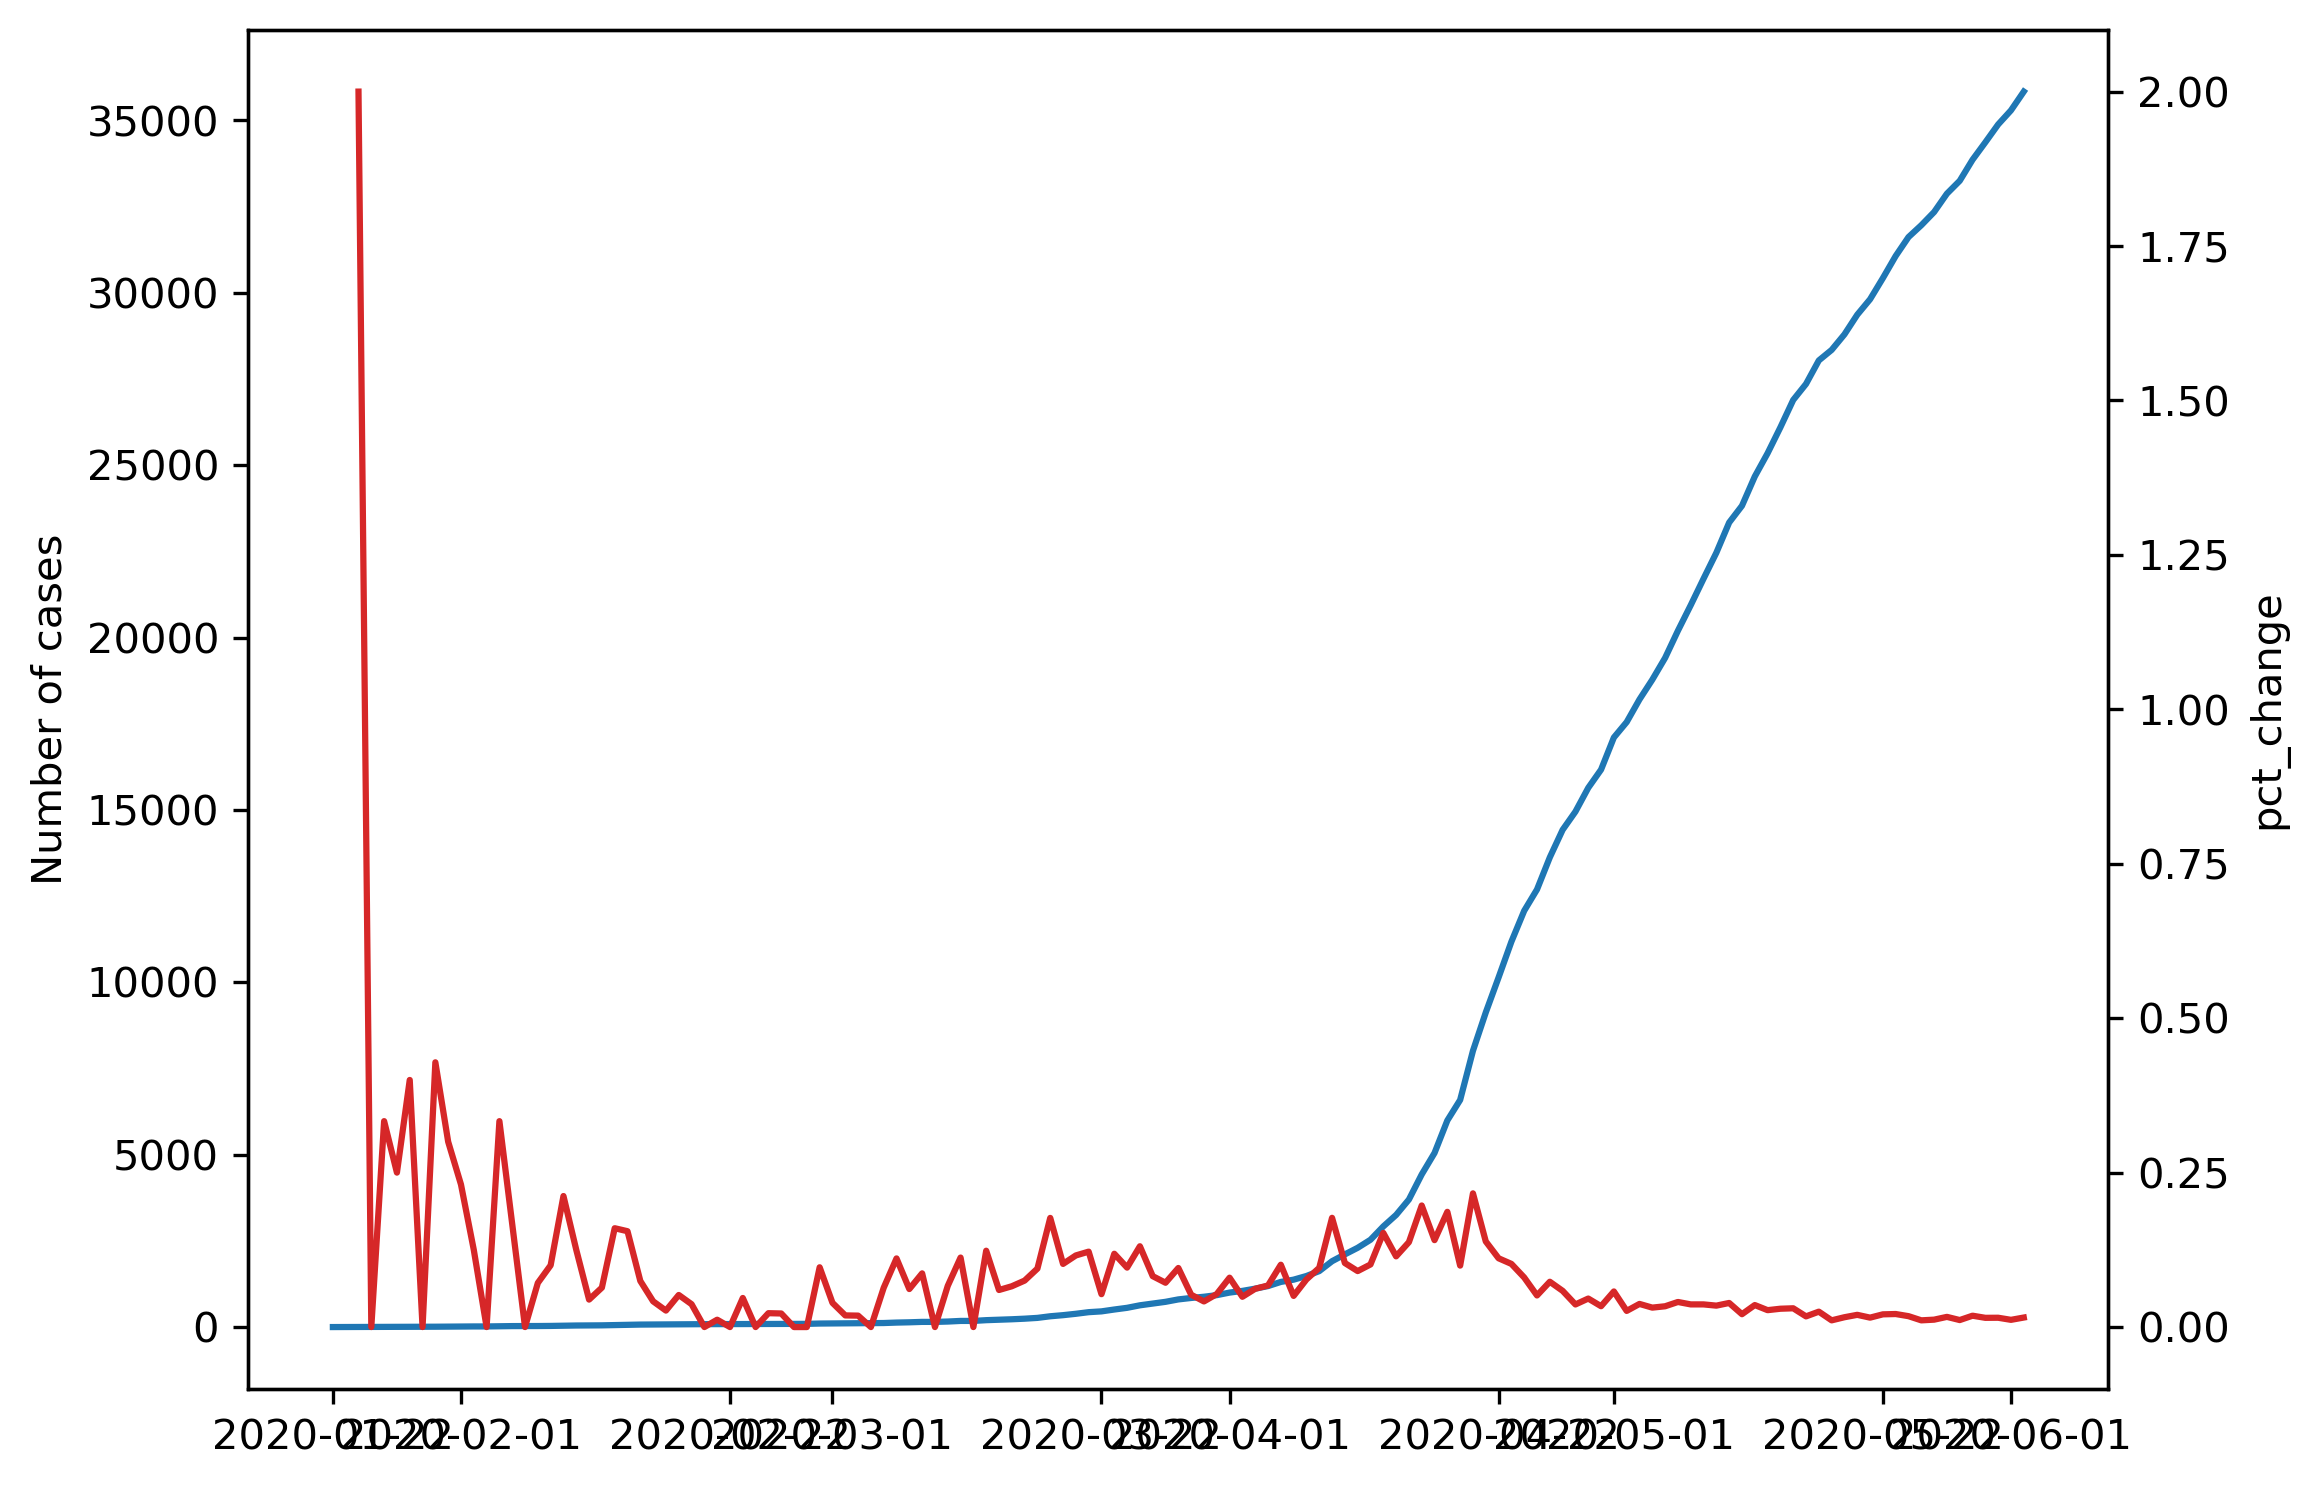

In [19]:
cases_and_rate(df_by_country['Singapore'])

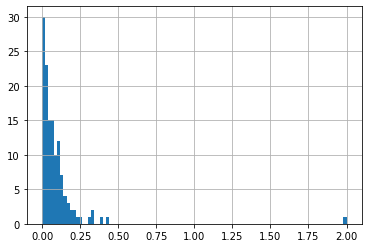

In [20]:
(df_by_country['Singapore'].pct_change()
 .dropna()
 .replace([np.inf, -np.inf], np.nan)
 .hist(bins=100)
)

## Germany

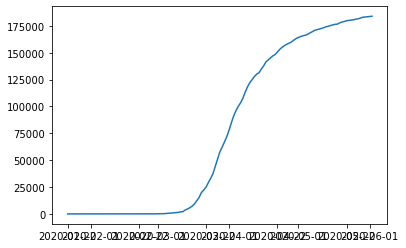

In [21]:
df_by_country['Germany'].plot()

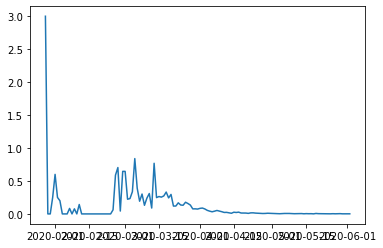

In [22]:
df_by_country['Germany'].pct_change().plot()

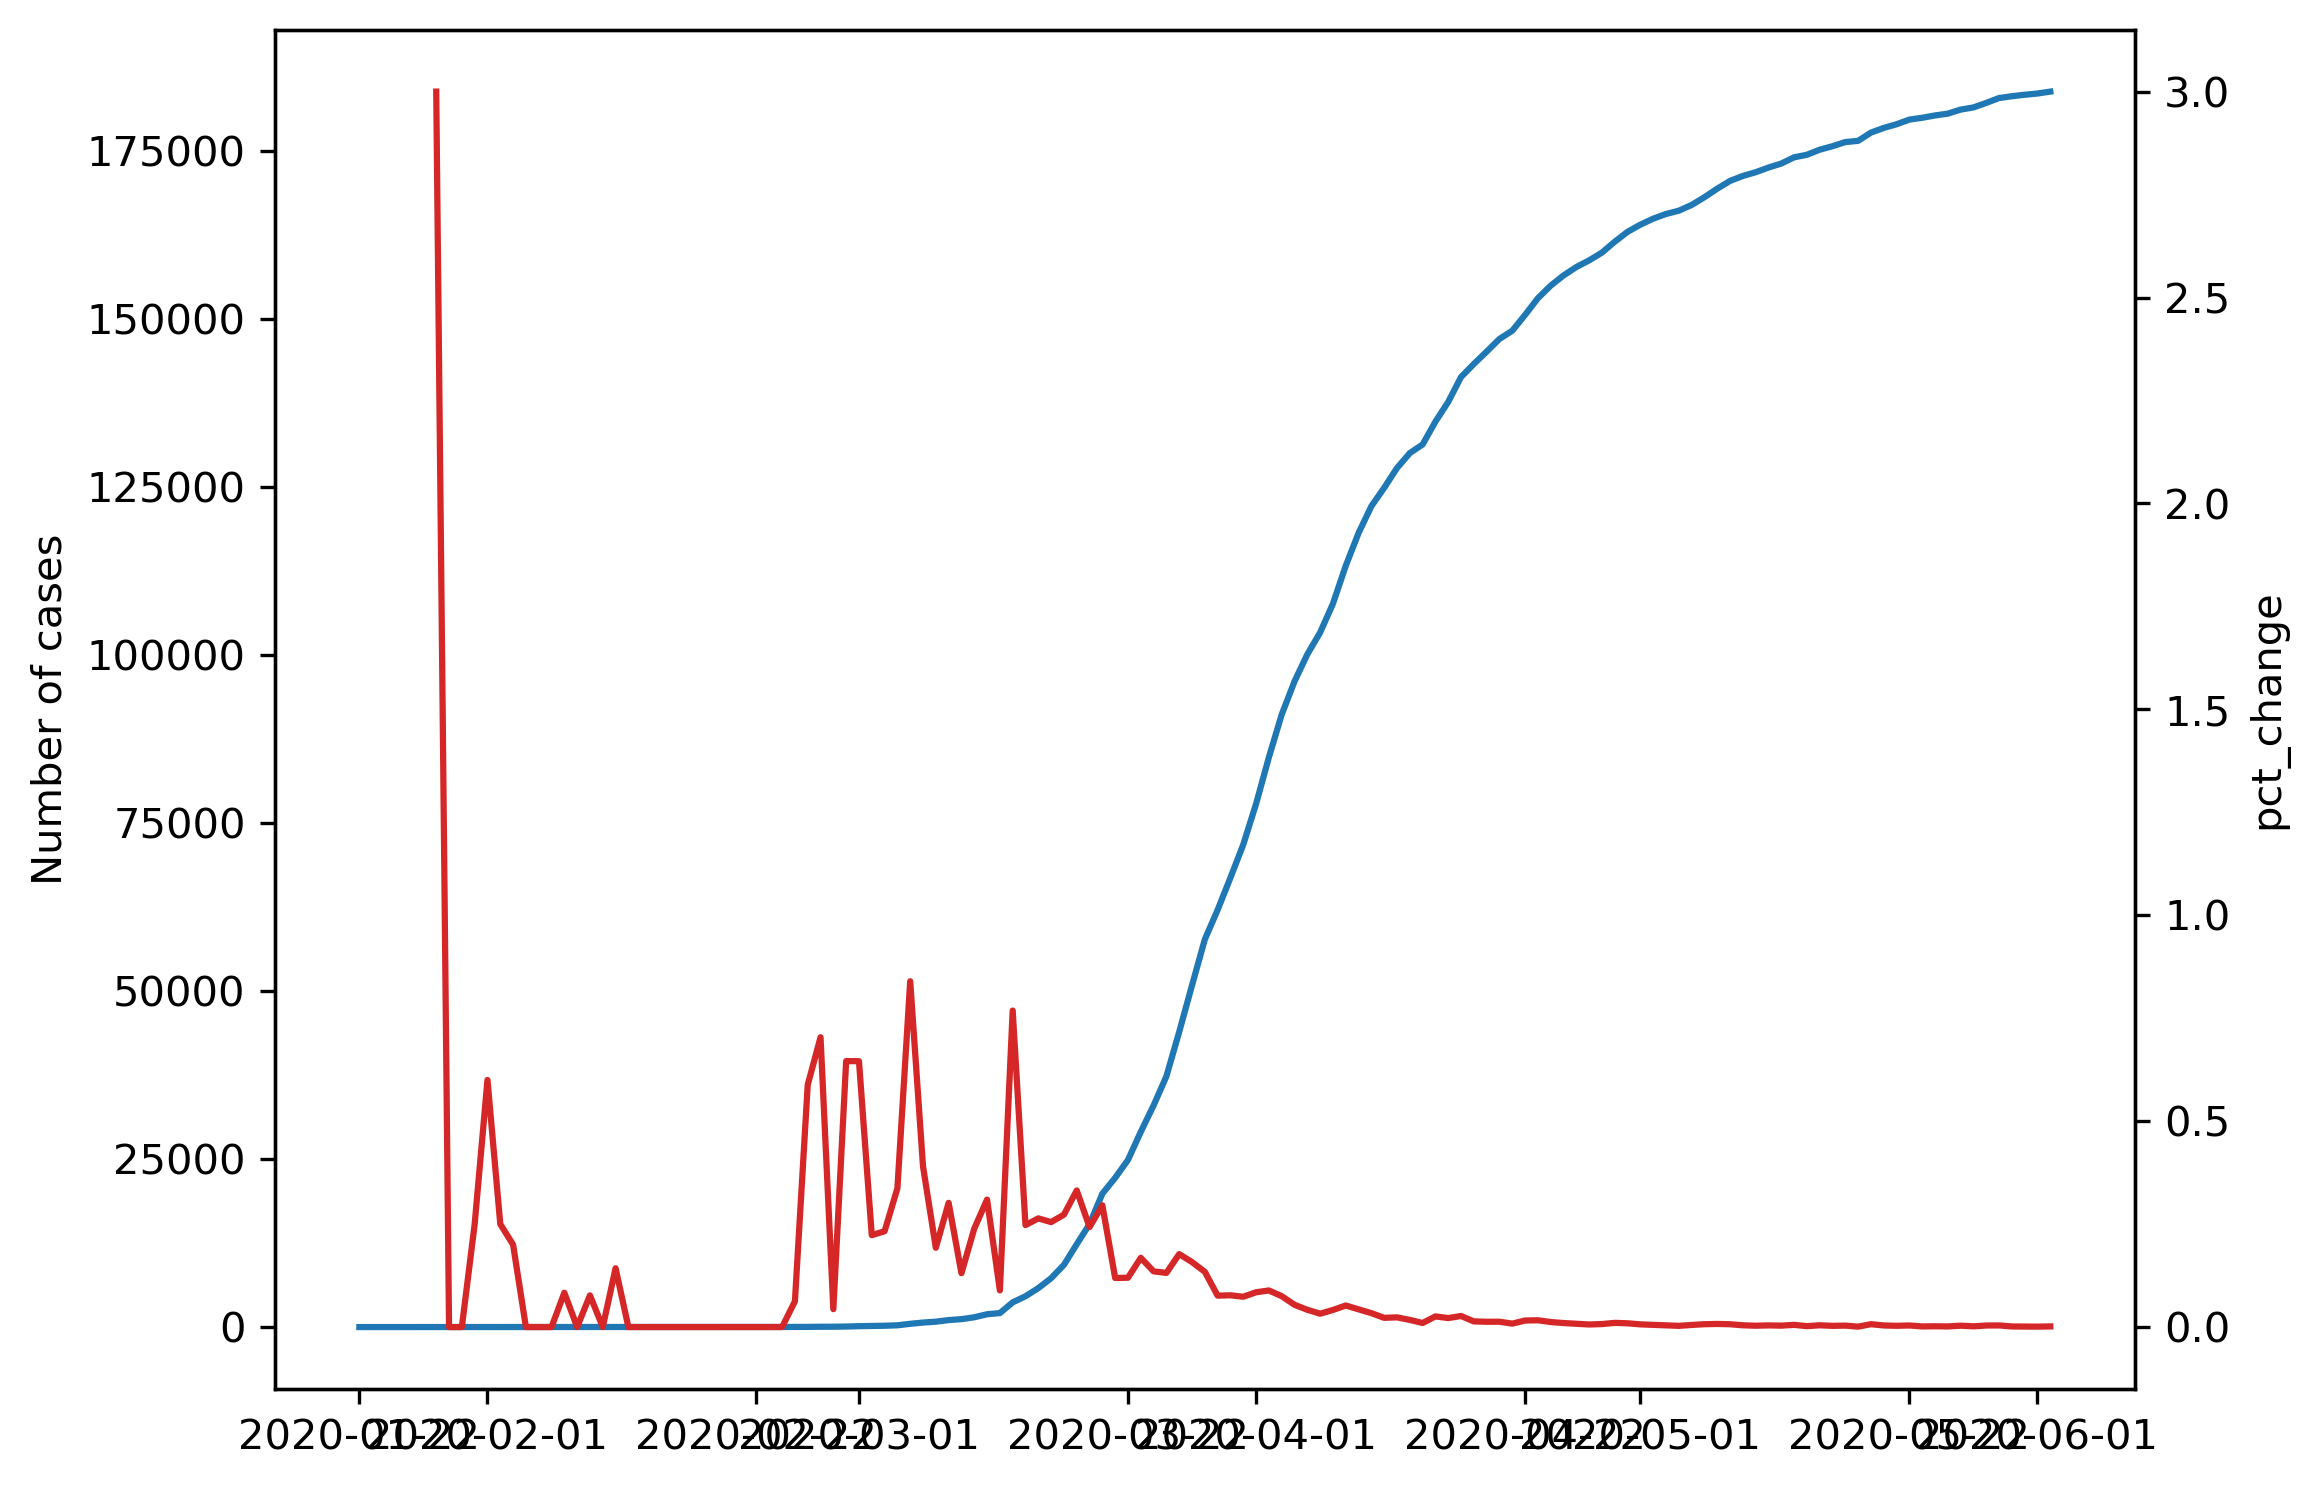

In [23]:
cases_and_rate(df_by_country['Germany'])

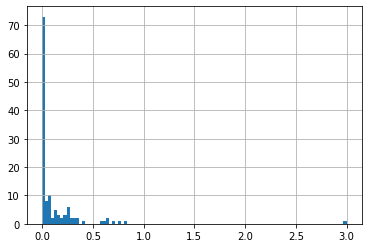

In [24]:
(df_by_country['Germany'].pct_change()
 .dropna()
 .replace([np.inf, -np.inf], np.nan)
 .hist(bins=100)
)

## United States

In [25]:
df_by_country.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country/Region', length=188)

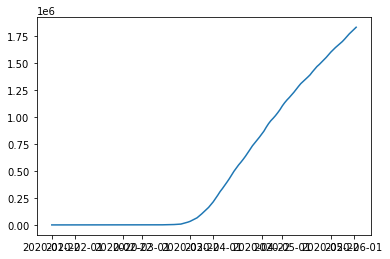

In [26]:
df_by_country['US'].plot()

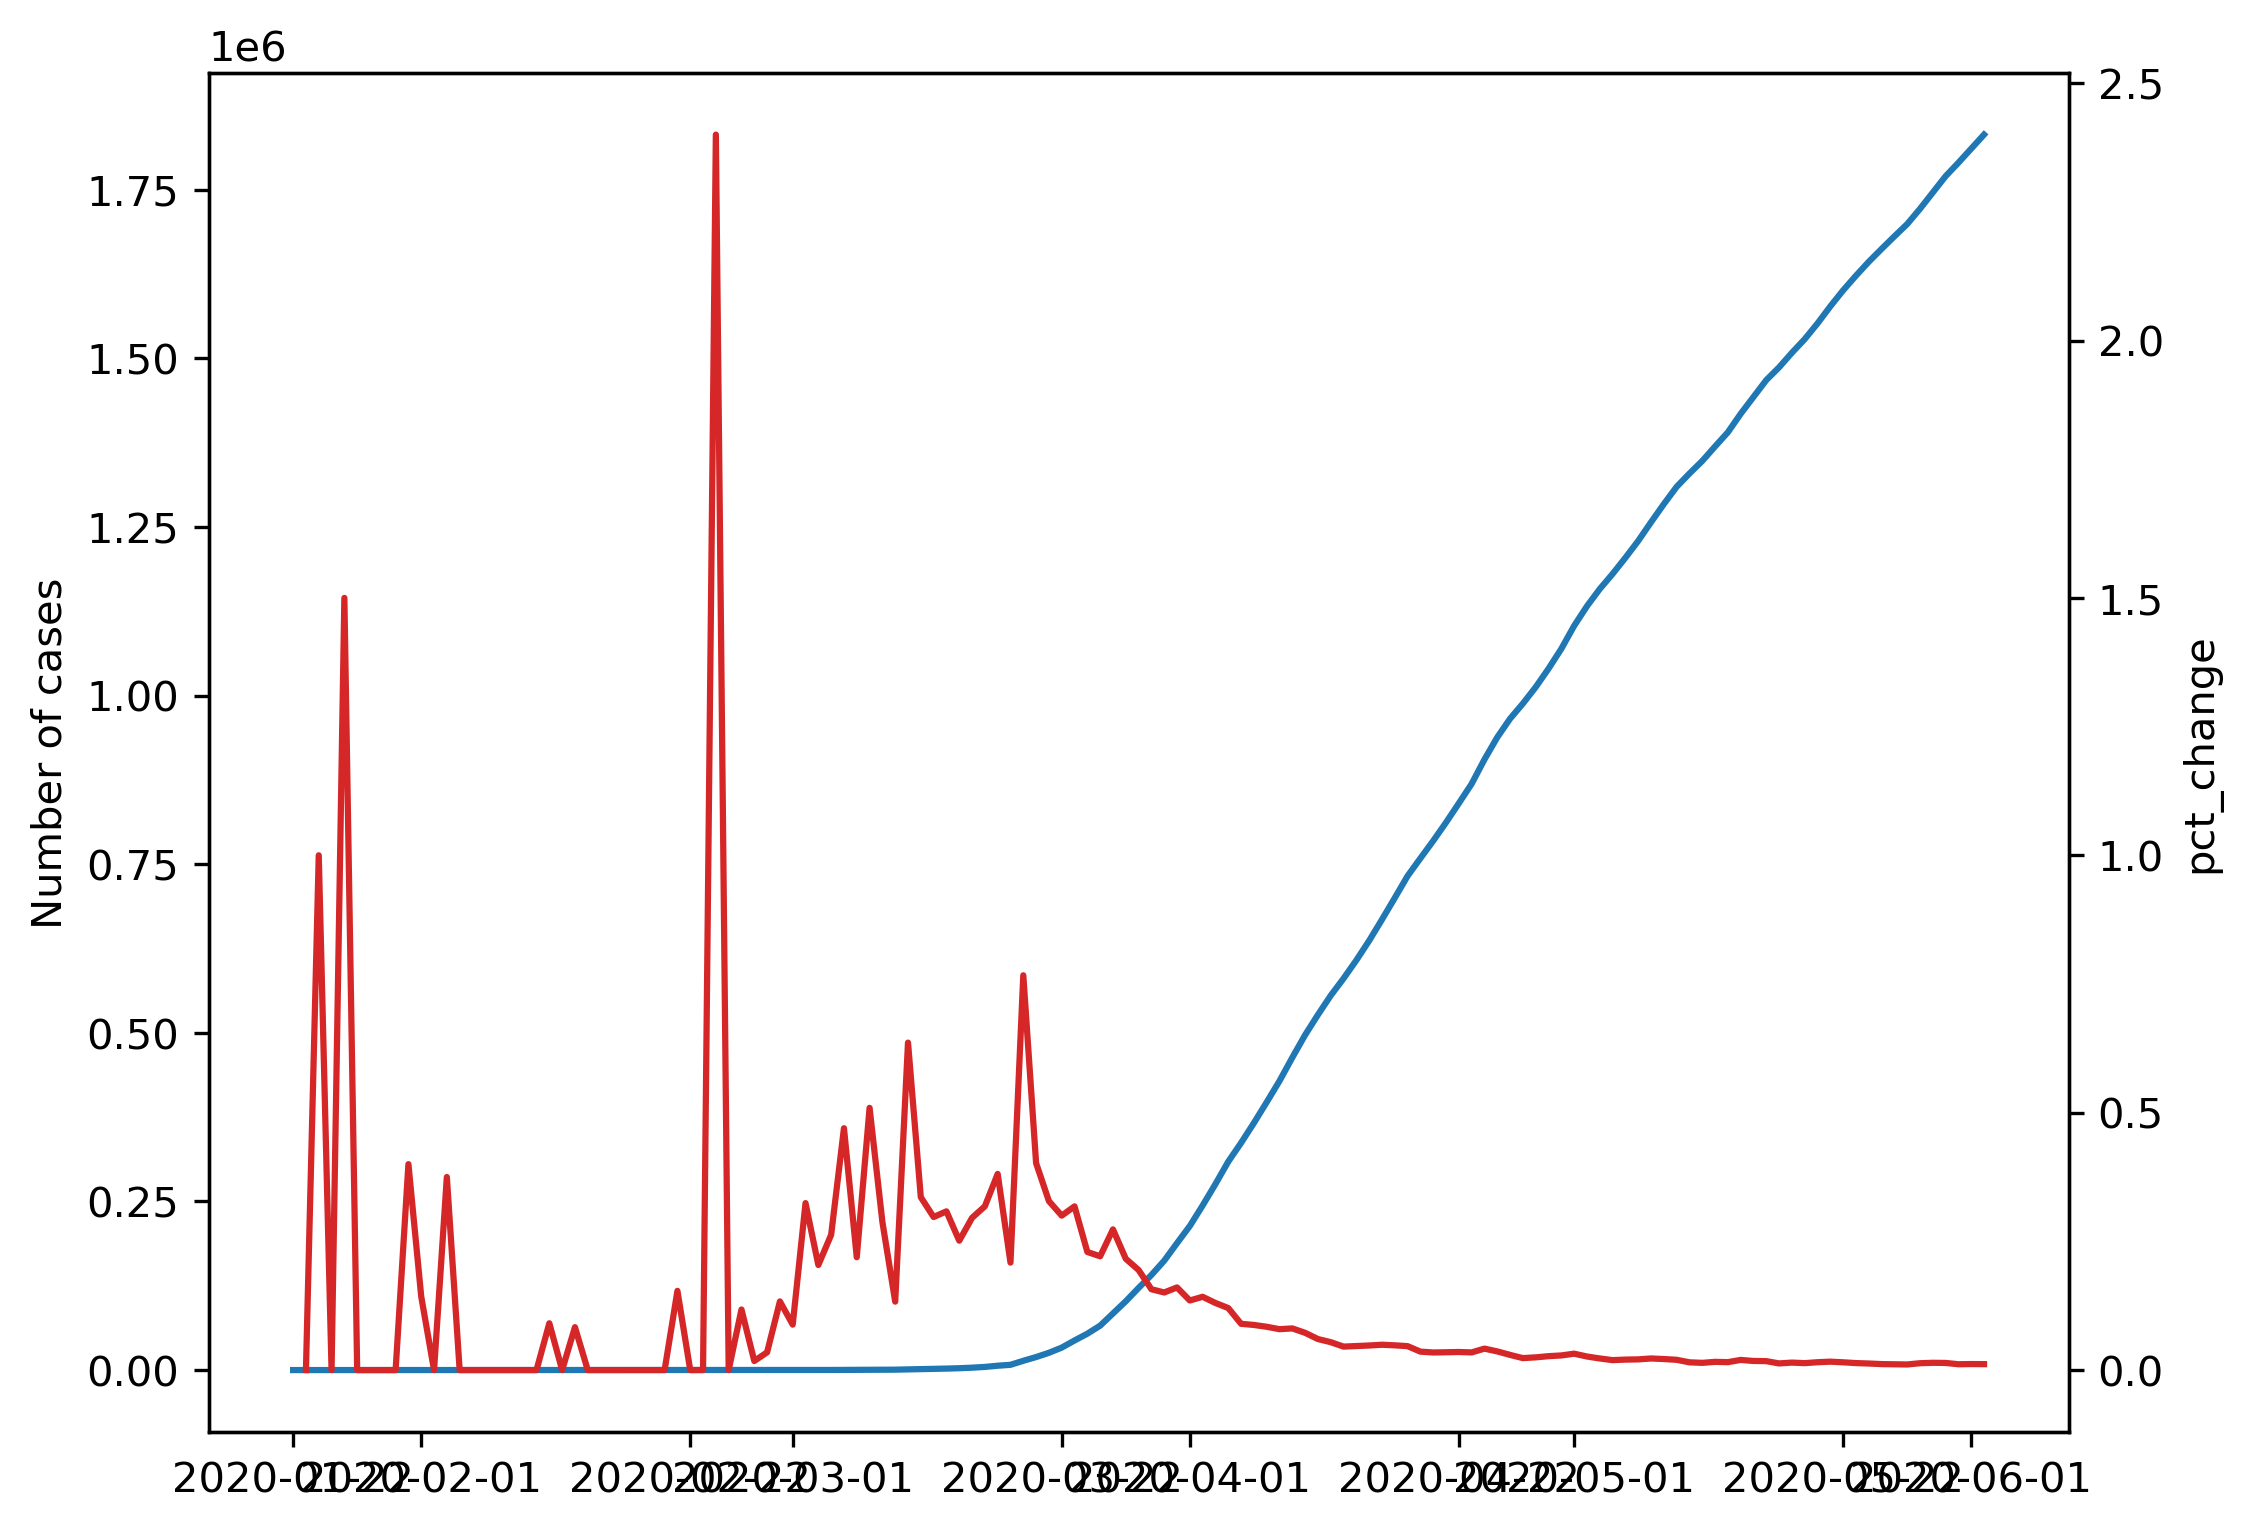

In [27]:
cases_and_rate(df_by_country['US'])

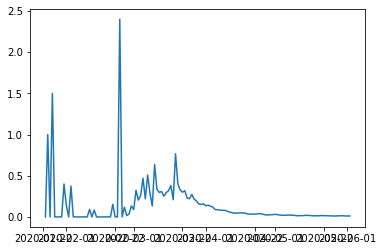

In [28]:
df_by_country['US'].pct_change().plot()

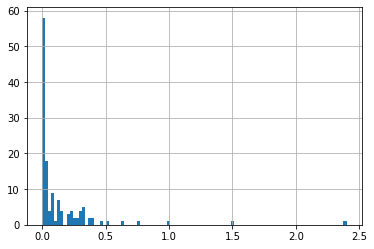

In [29]:
df_by_country['US'].pct_change().hist(bins=100)

## Italy

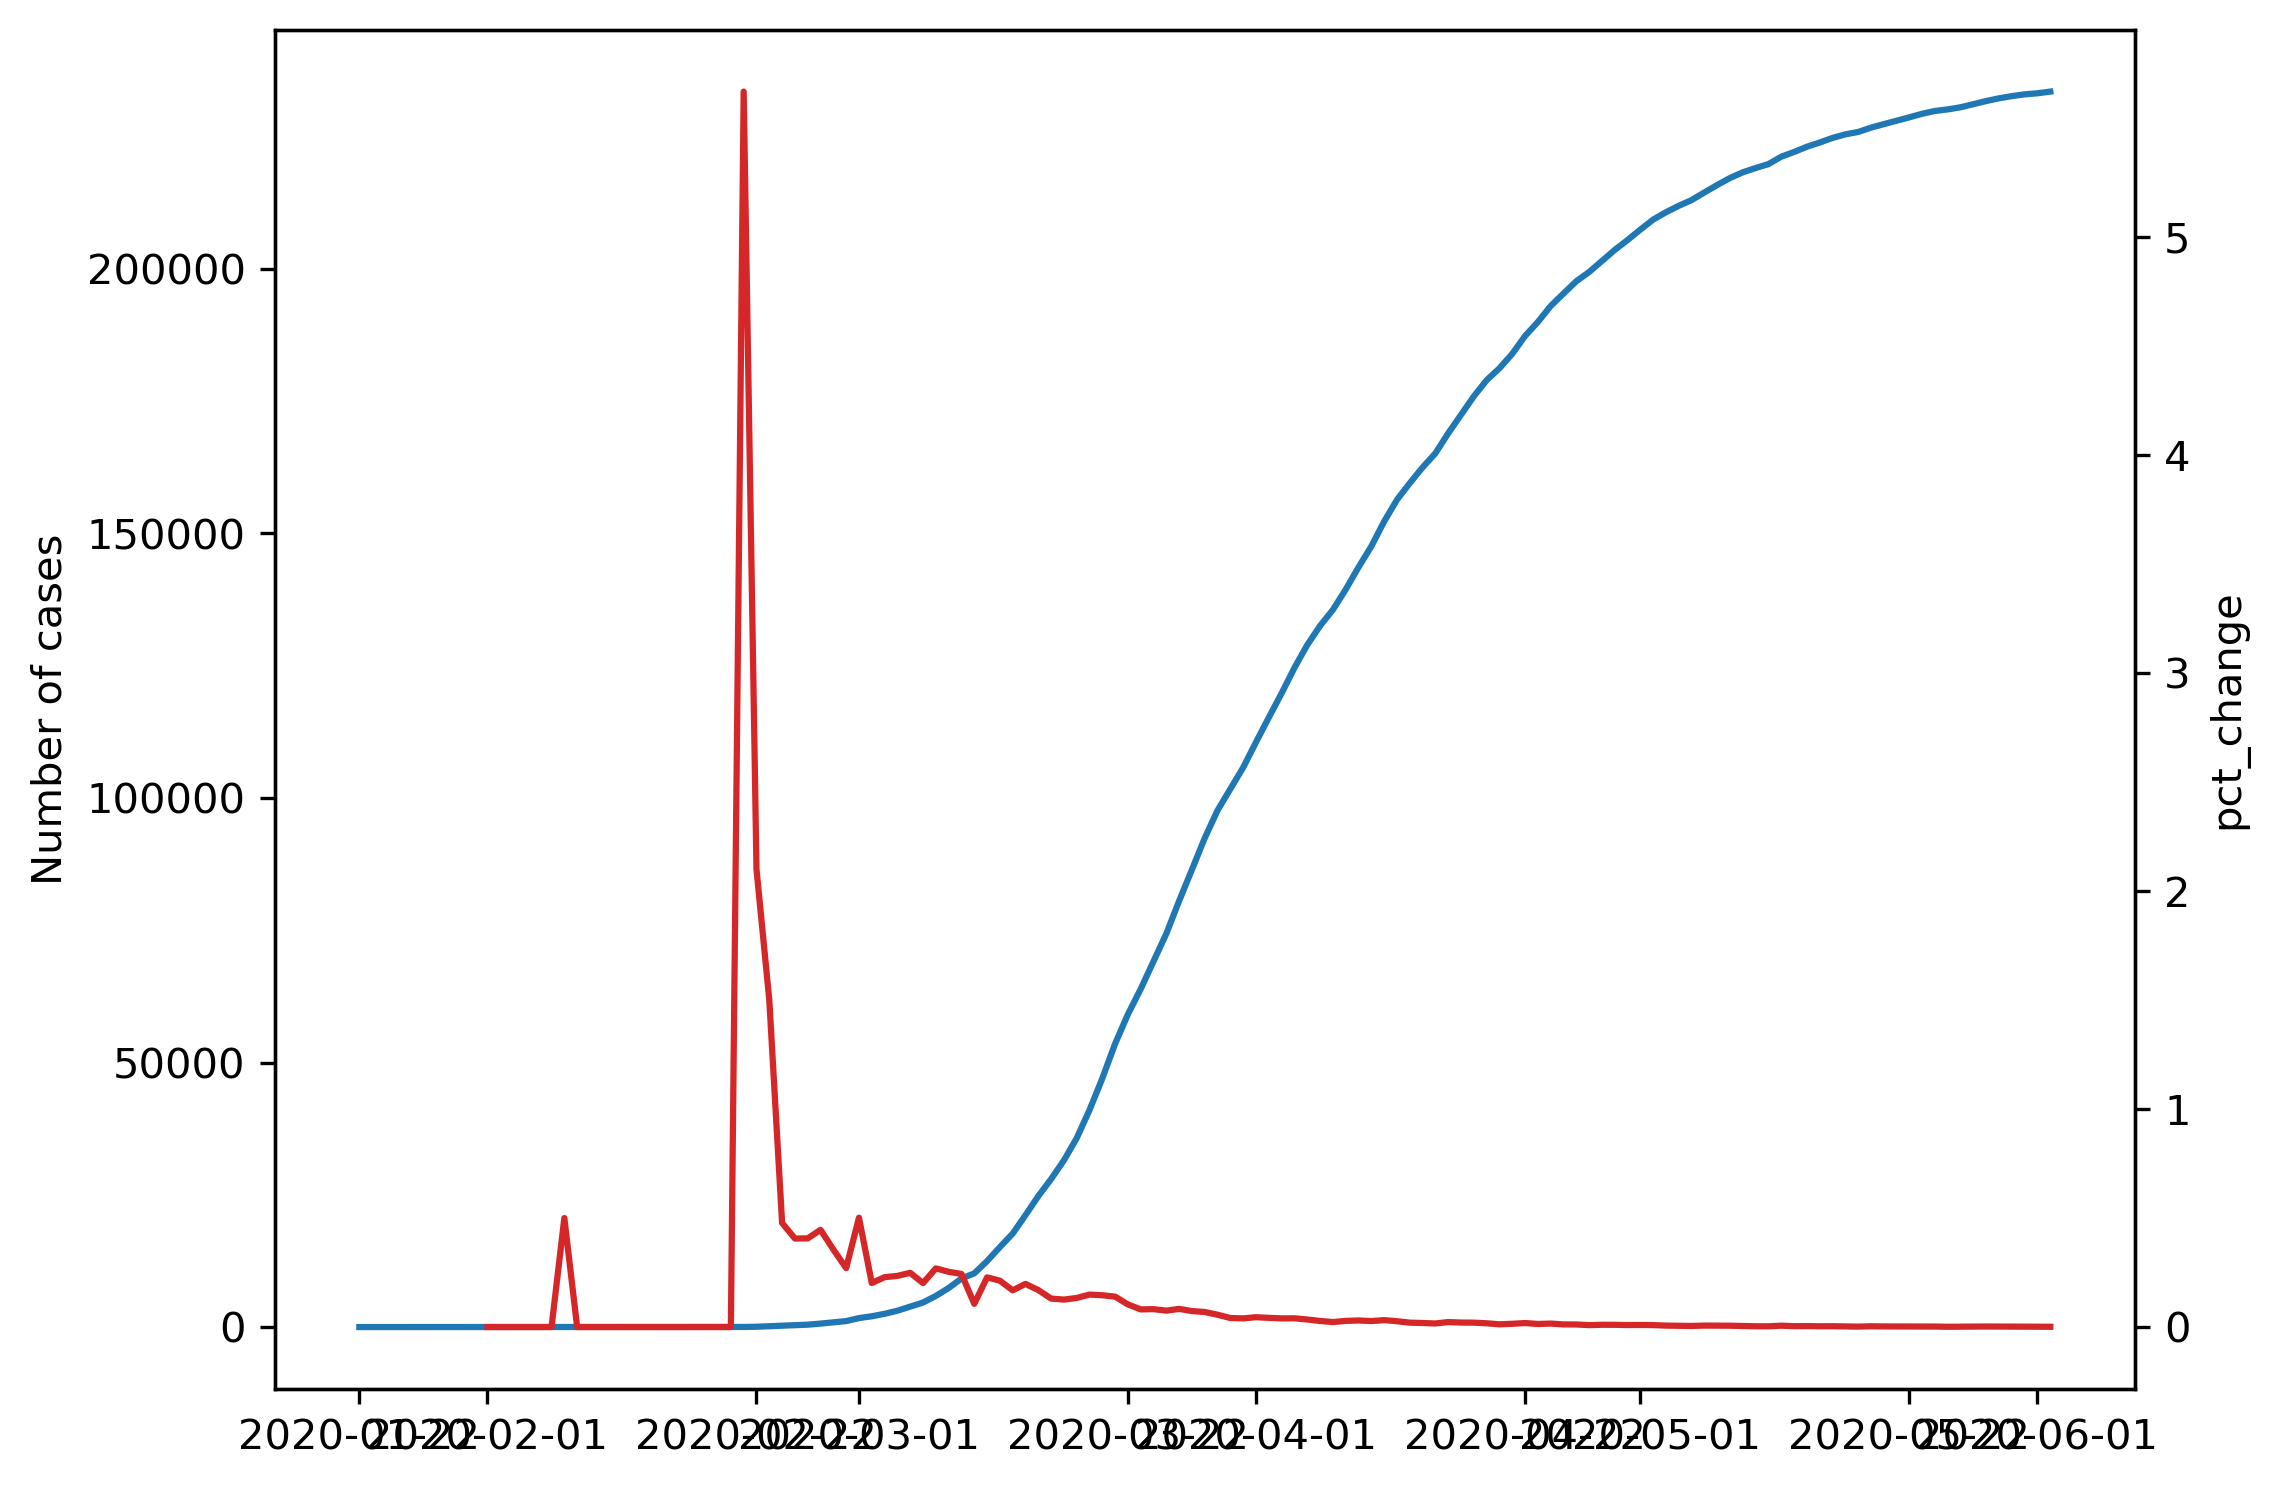

In [30]:
cases_and_rate(df_by_country['Italy'])

## Sweden
Of interest as a country that has not imposed any lockdown measures.

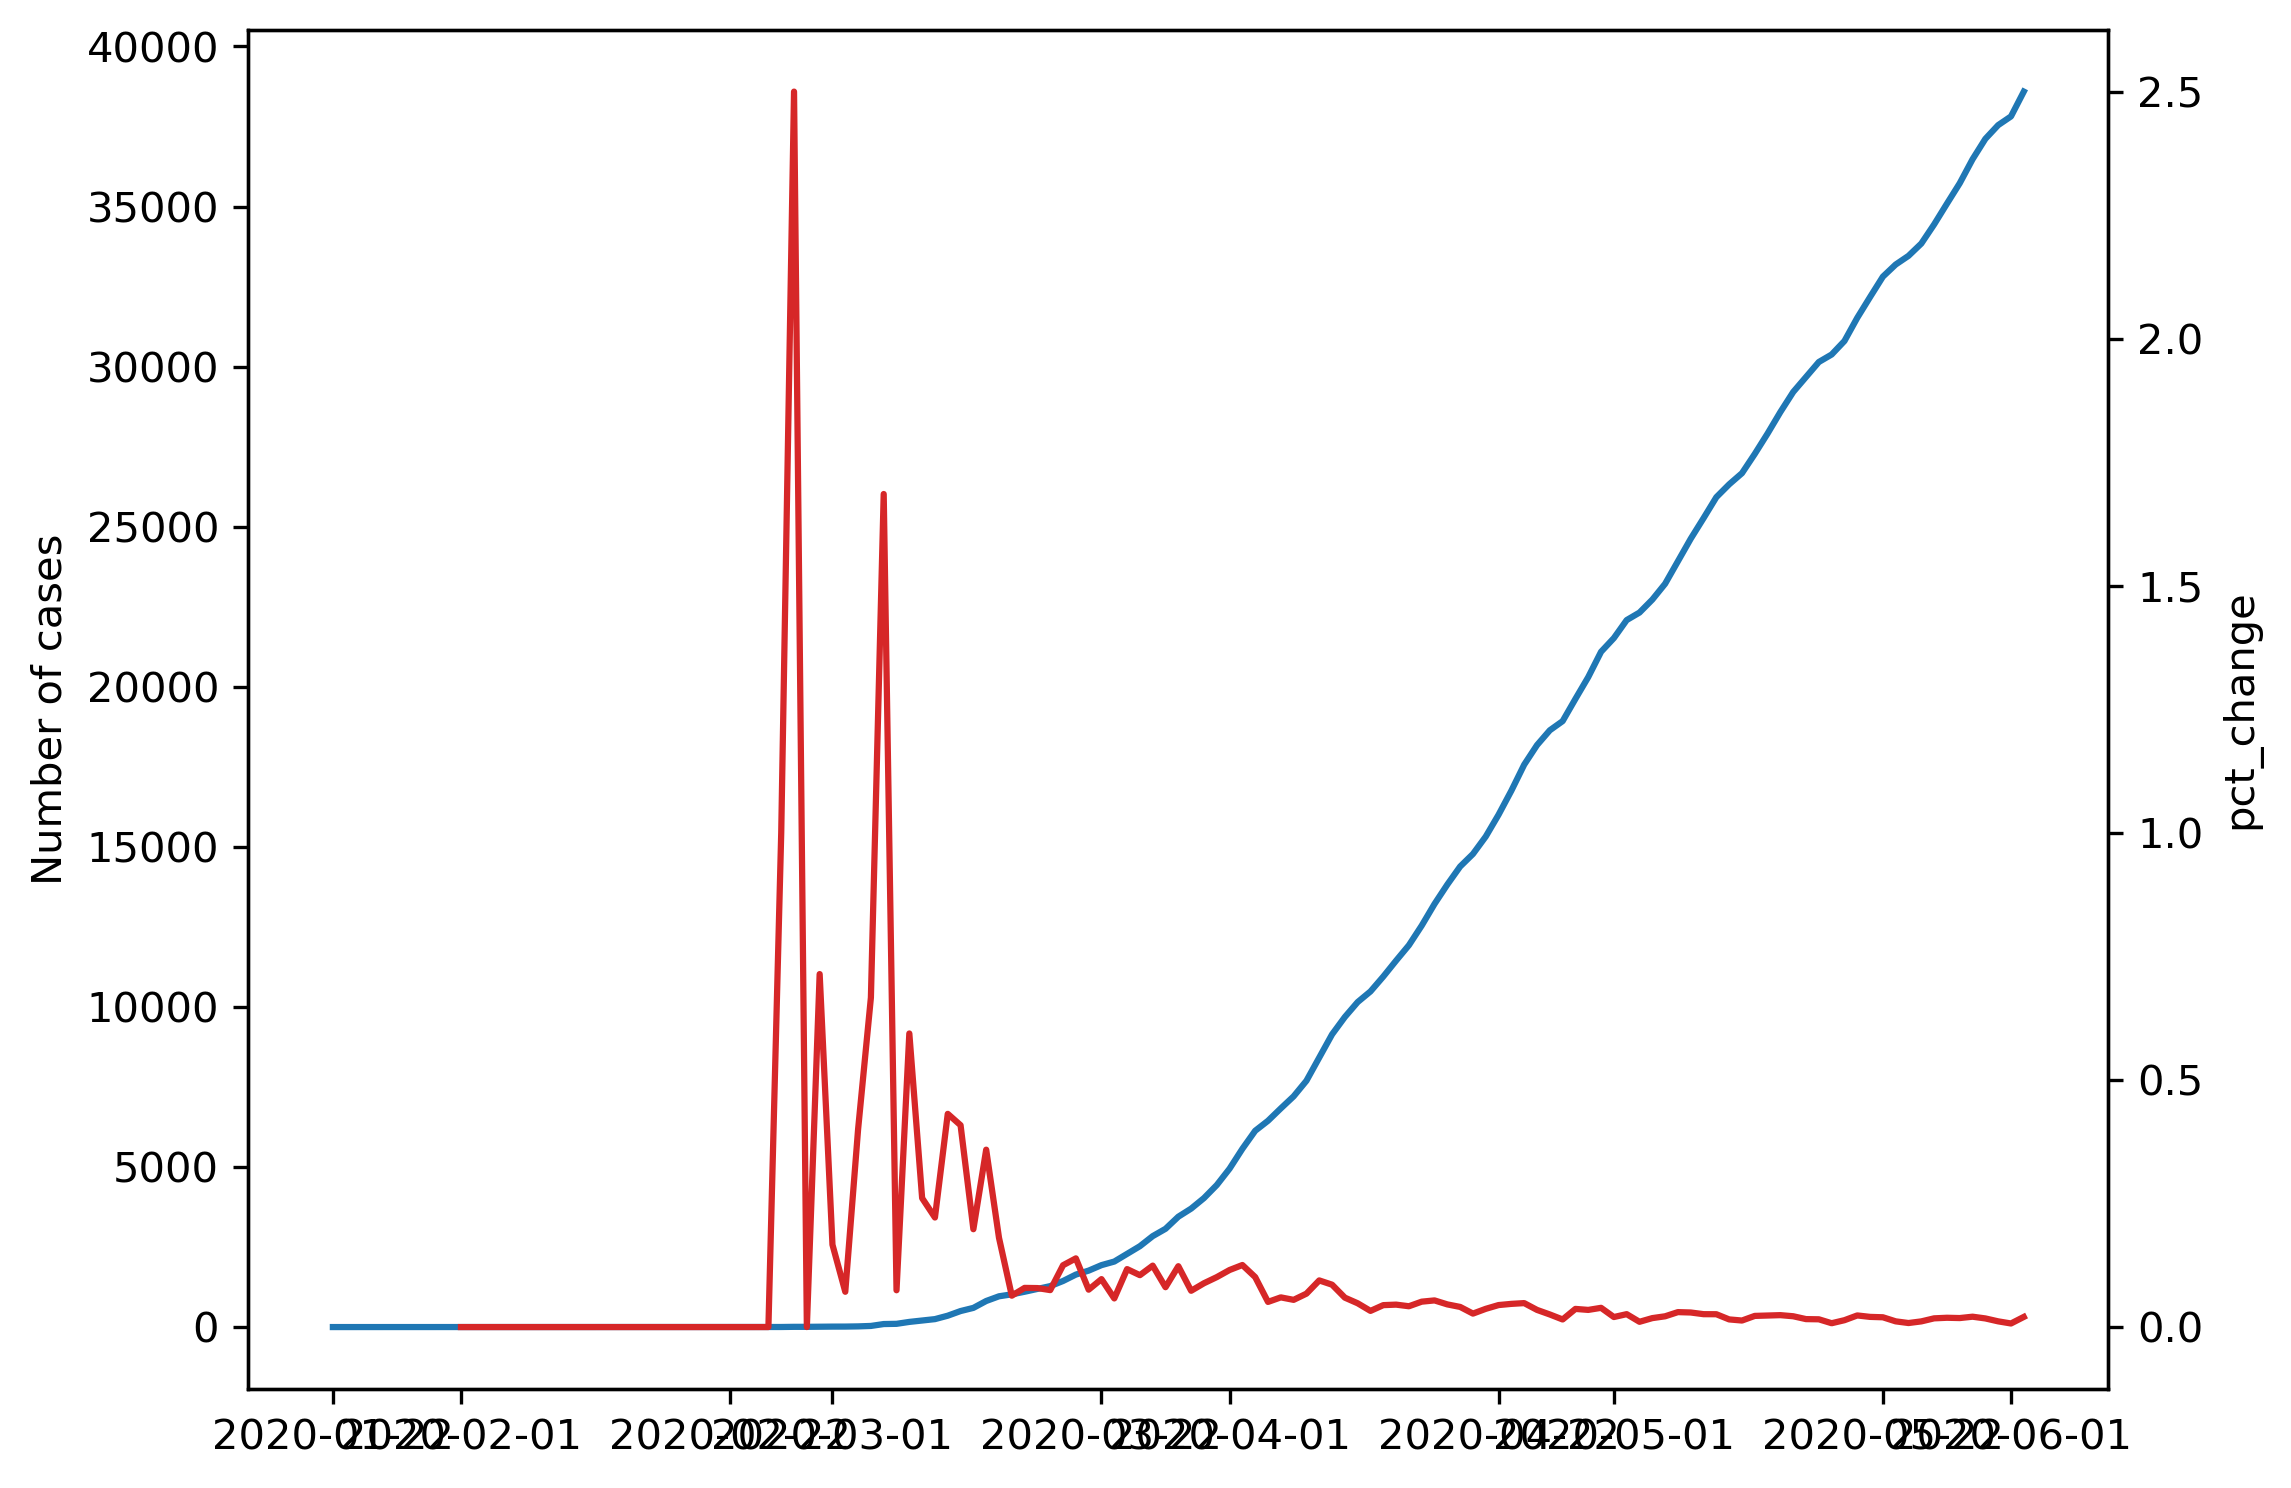

In [31]:
cases_and_rate(df_by_country['Sweden'])

## New Zealand

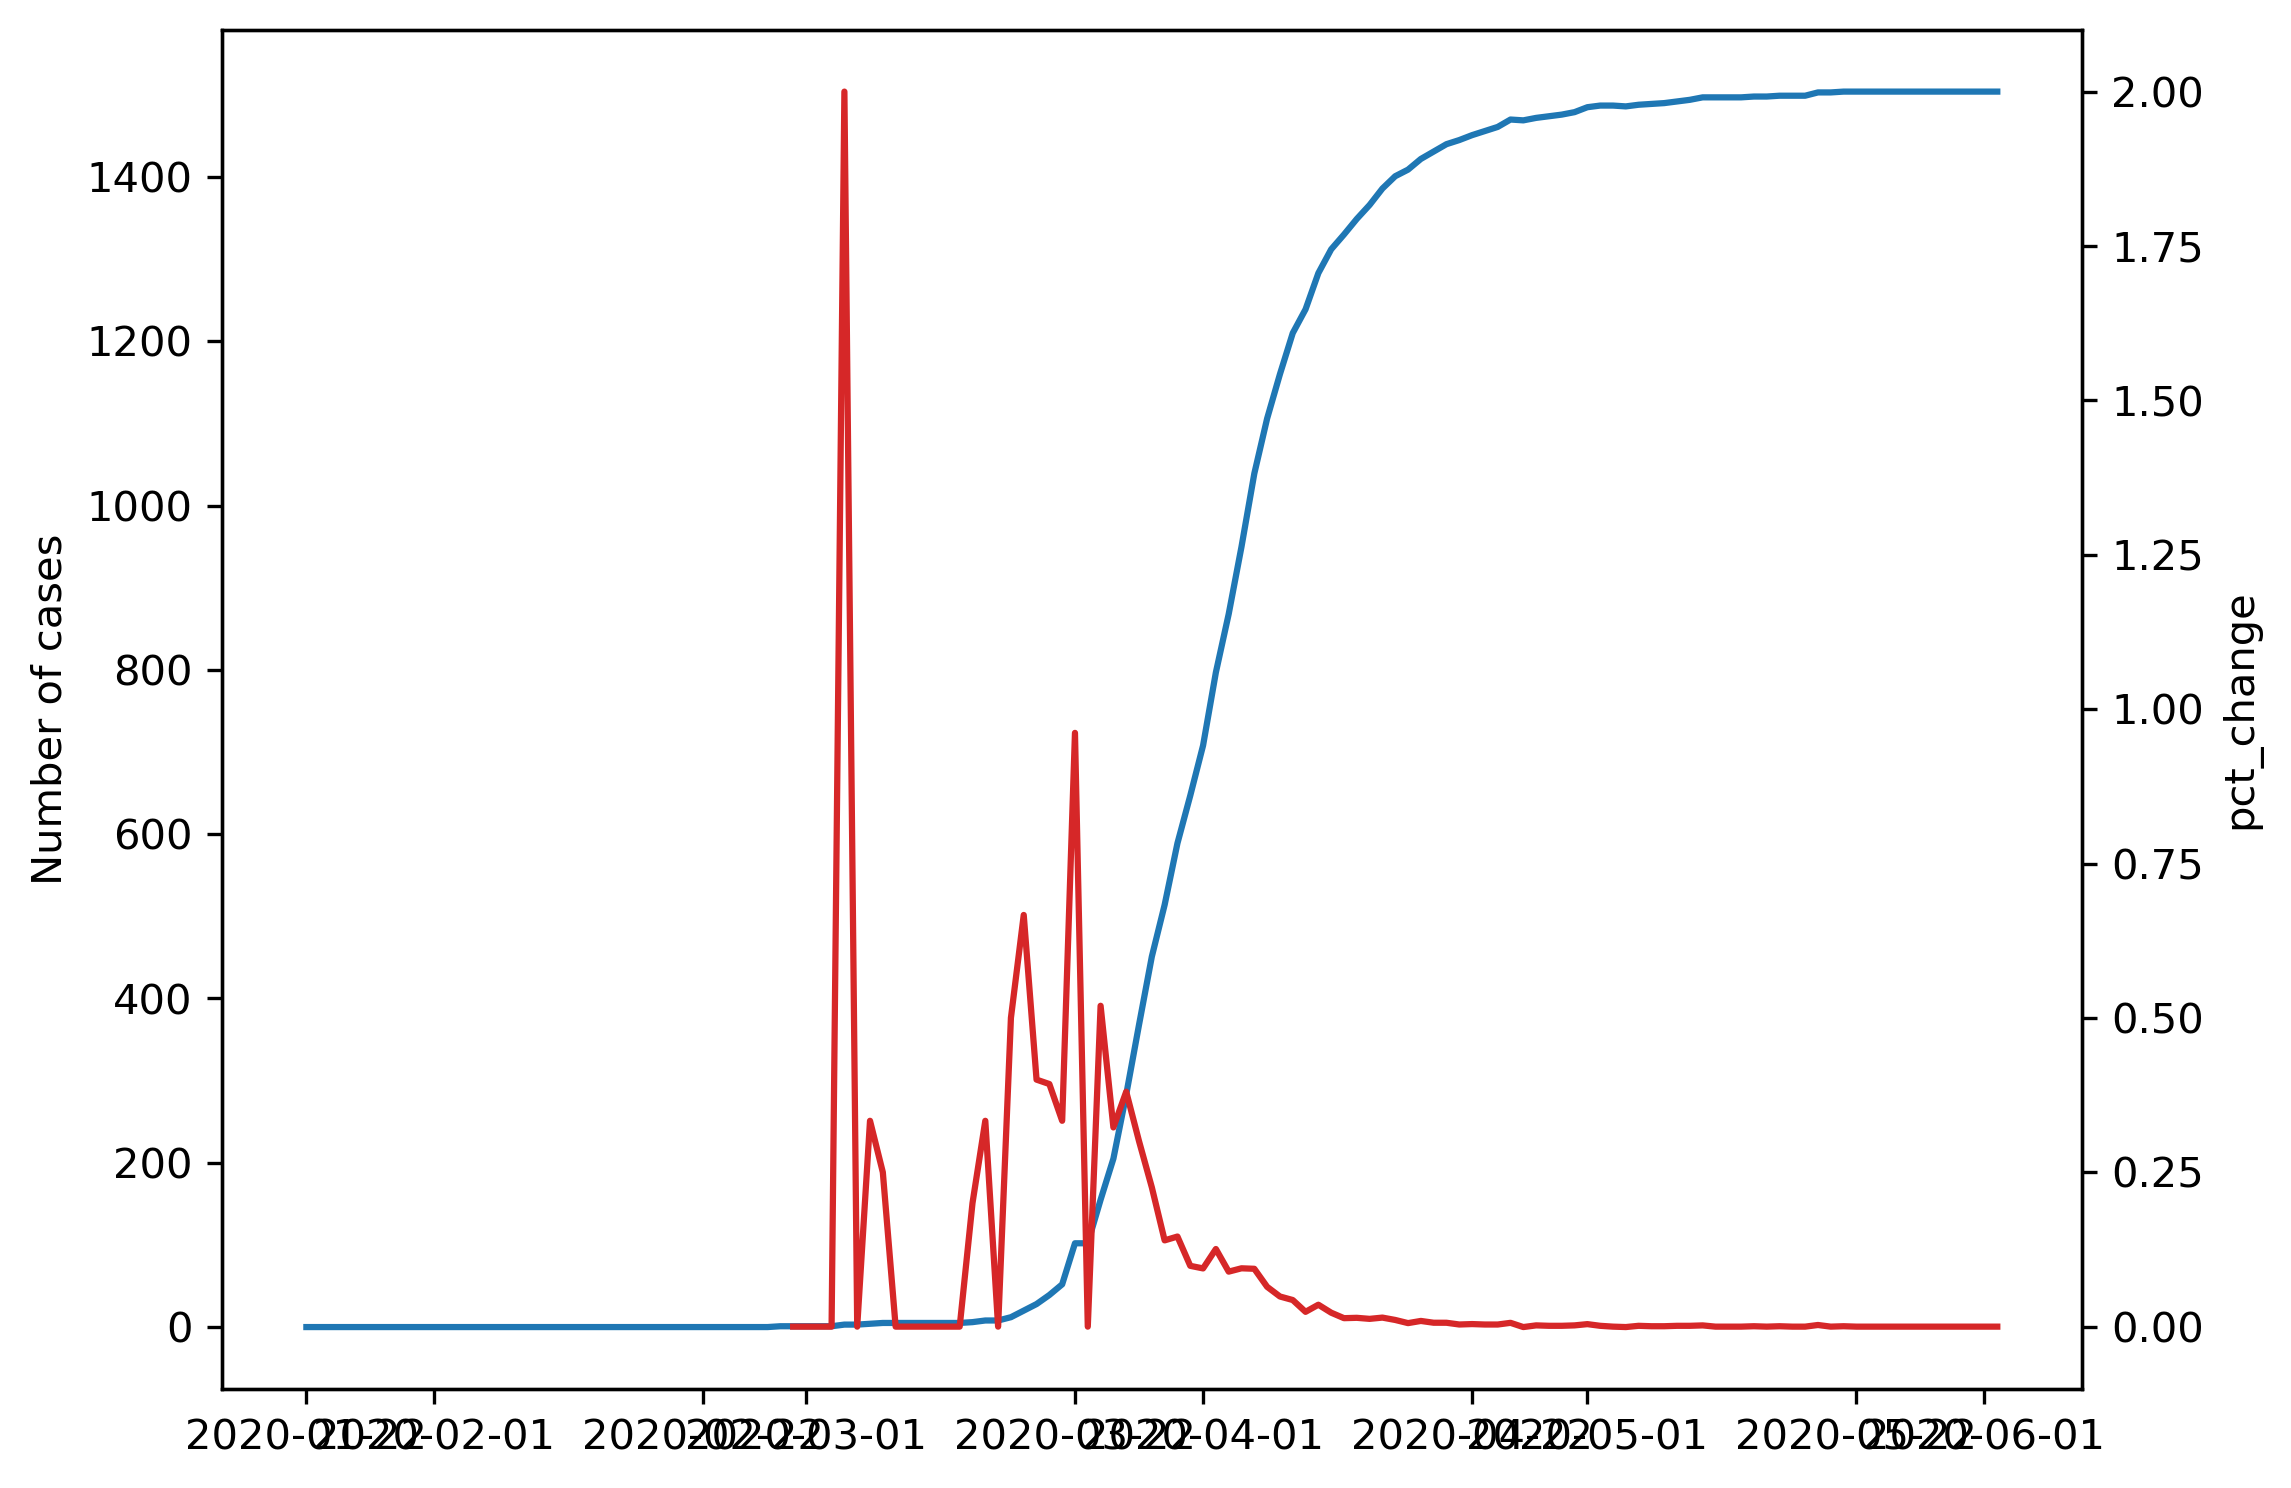

In [32]:
cases_and_rate(df_by_country['New Zealand'])

## Brazil

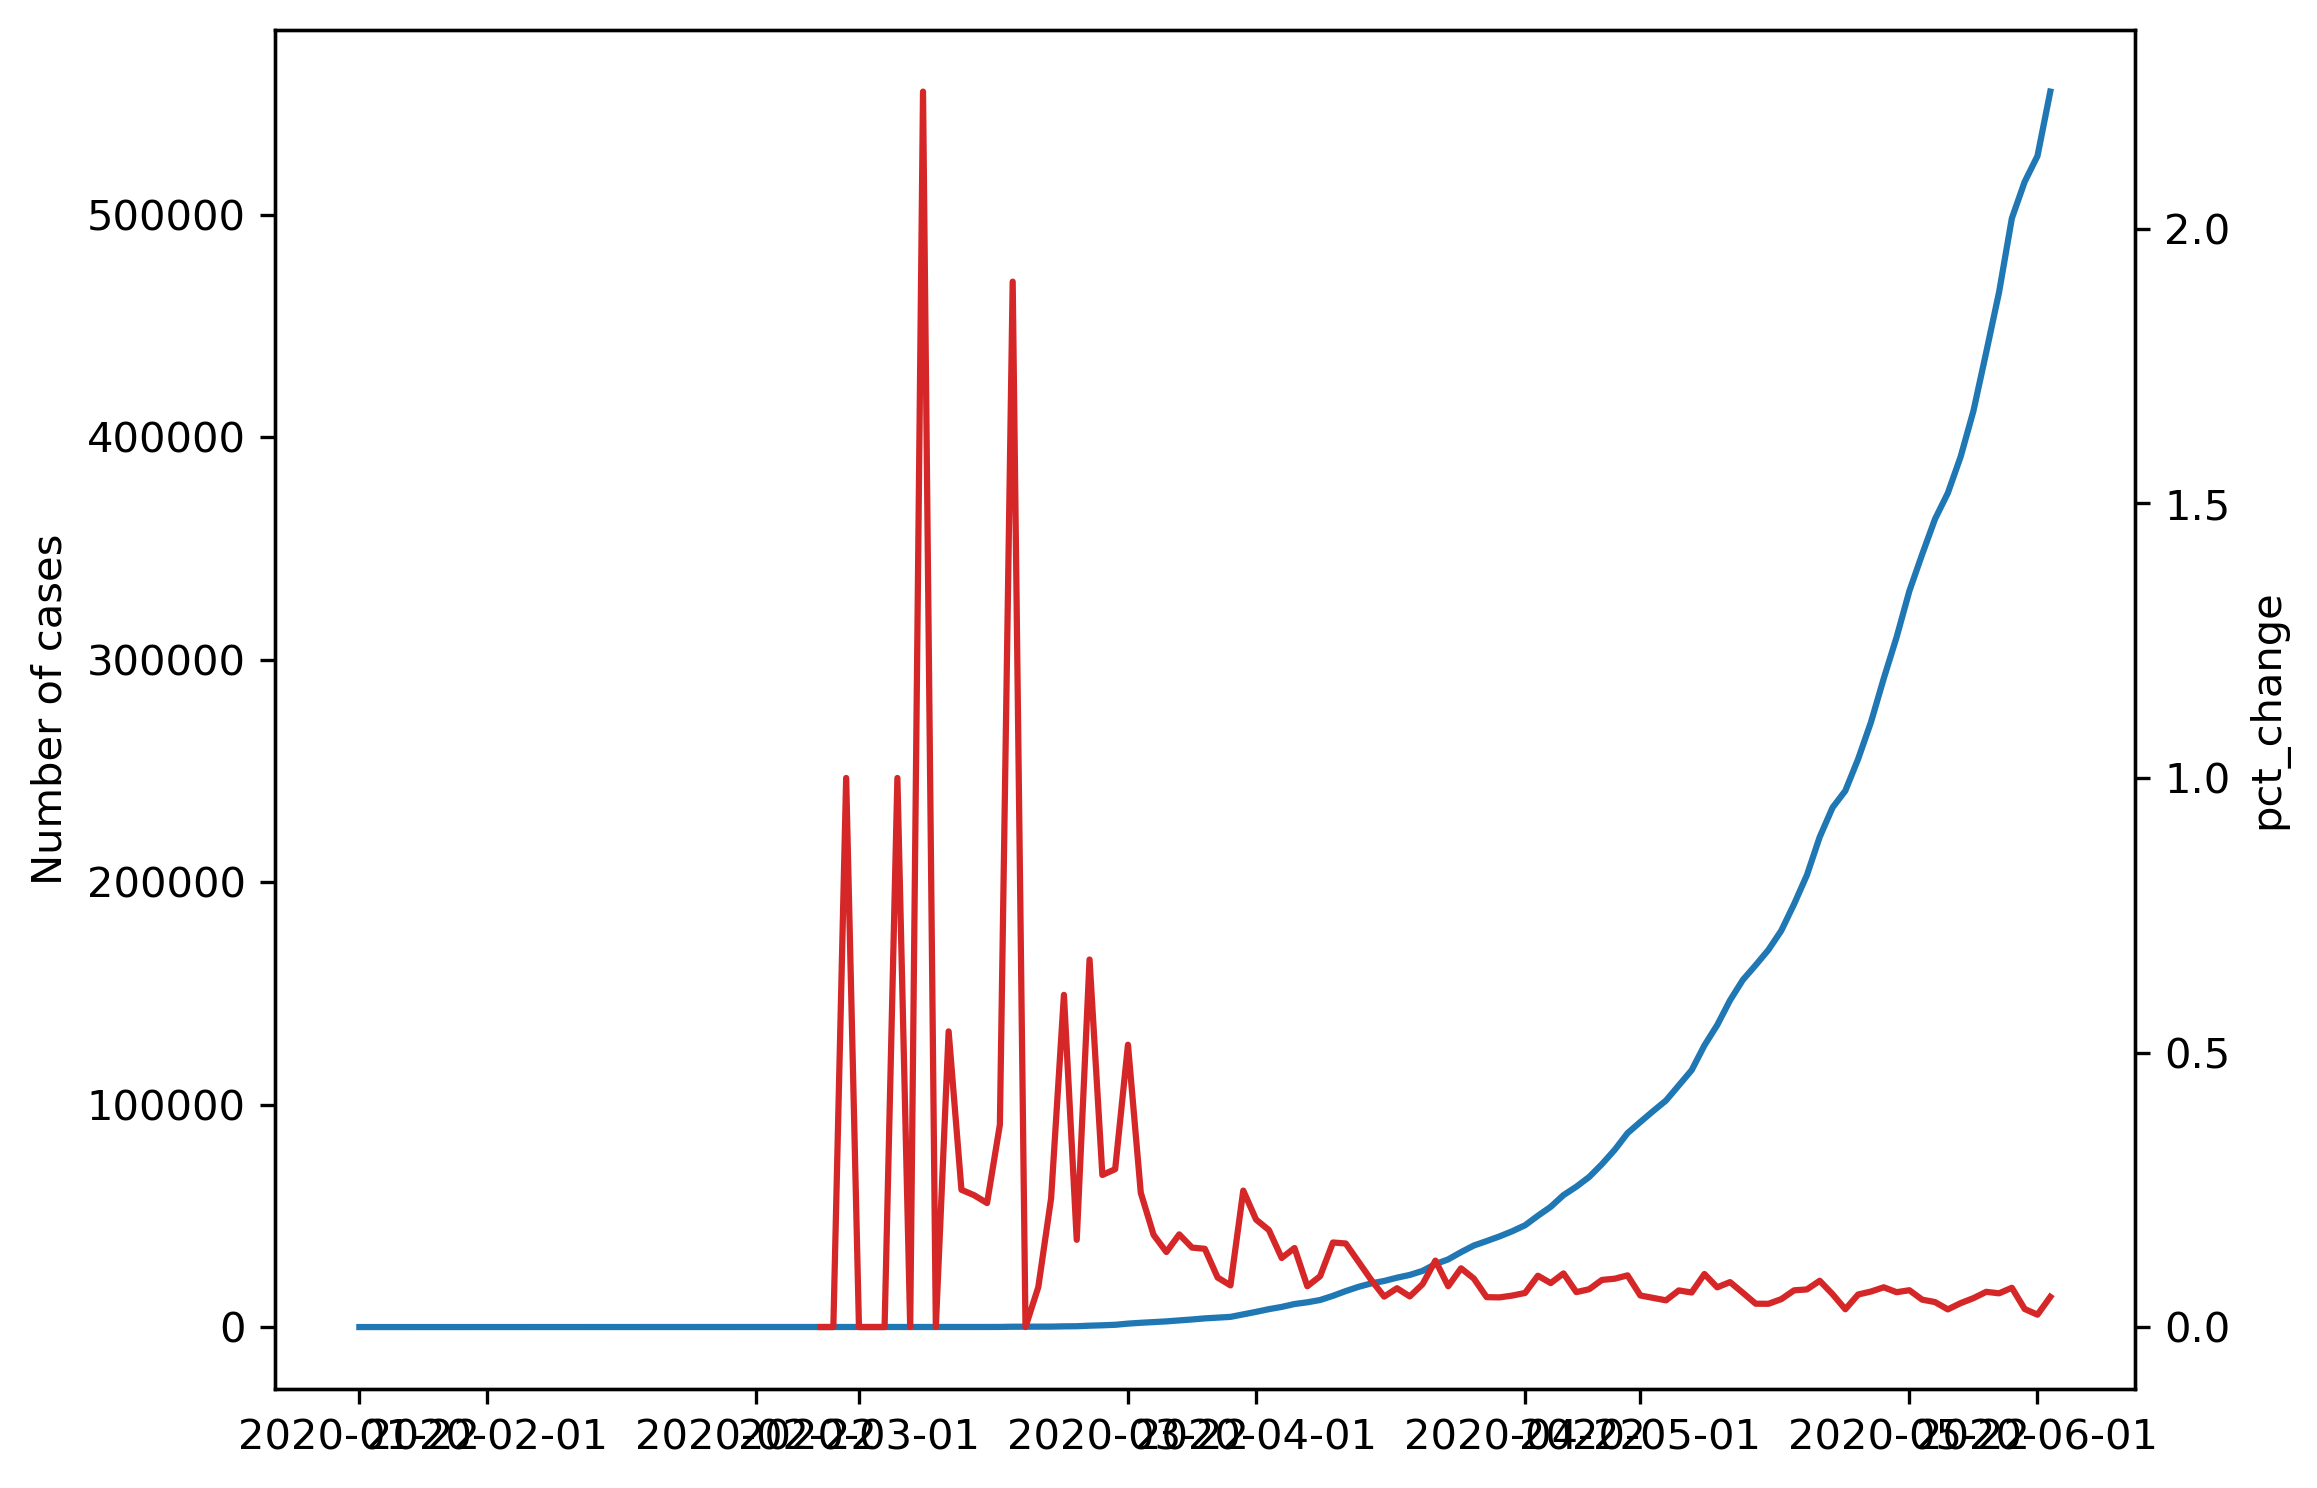

In [33]:
cases_and_rate(df_by_country['Brazil'])

## Exploring change rates

### Checking where a appropriate cutoff for visualising change rates is

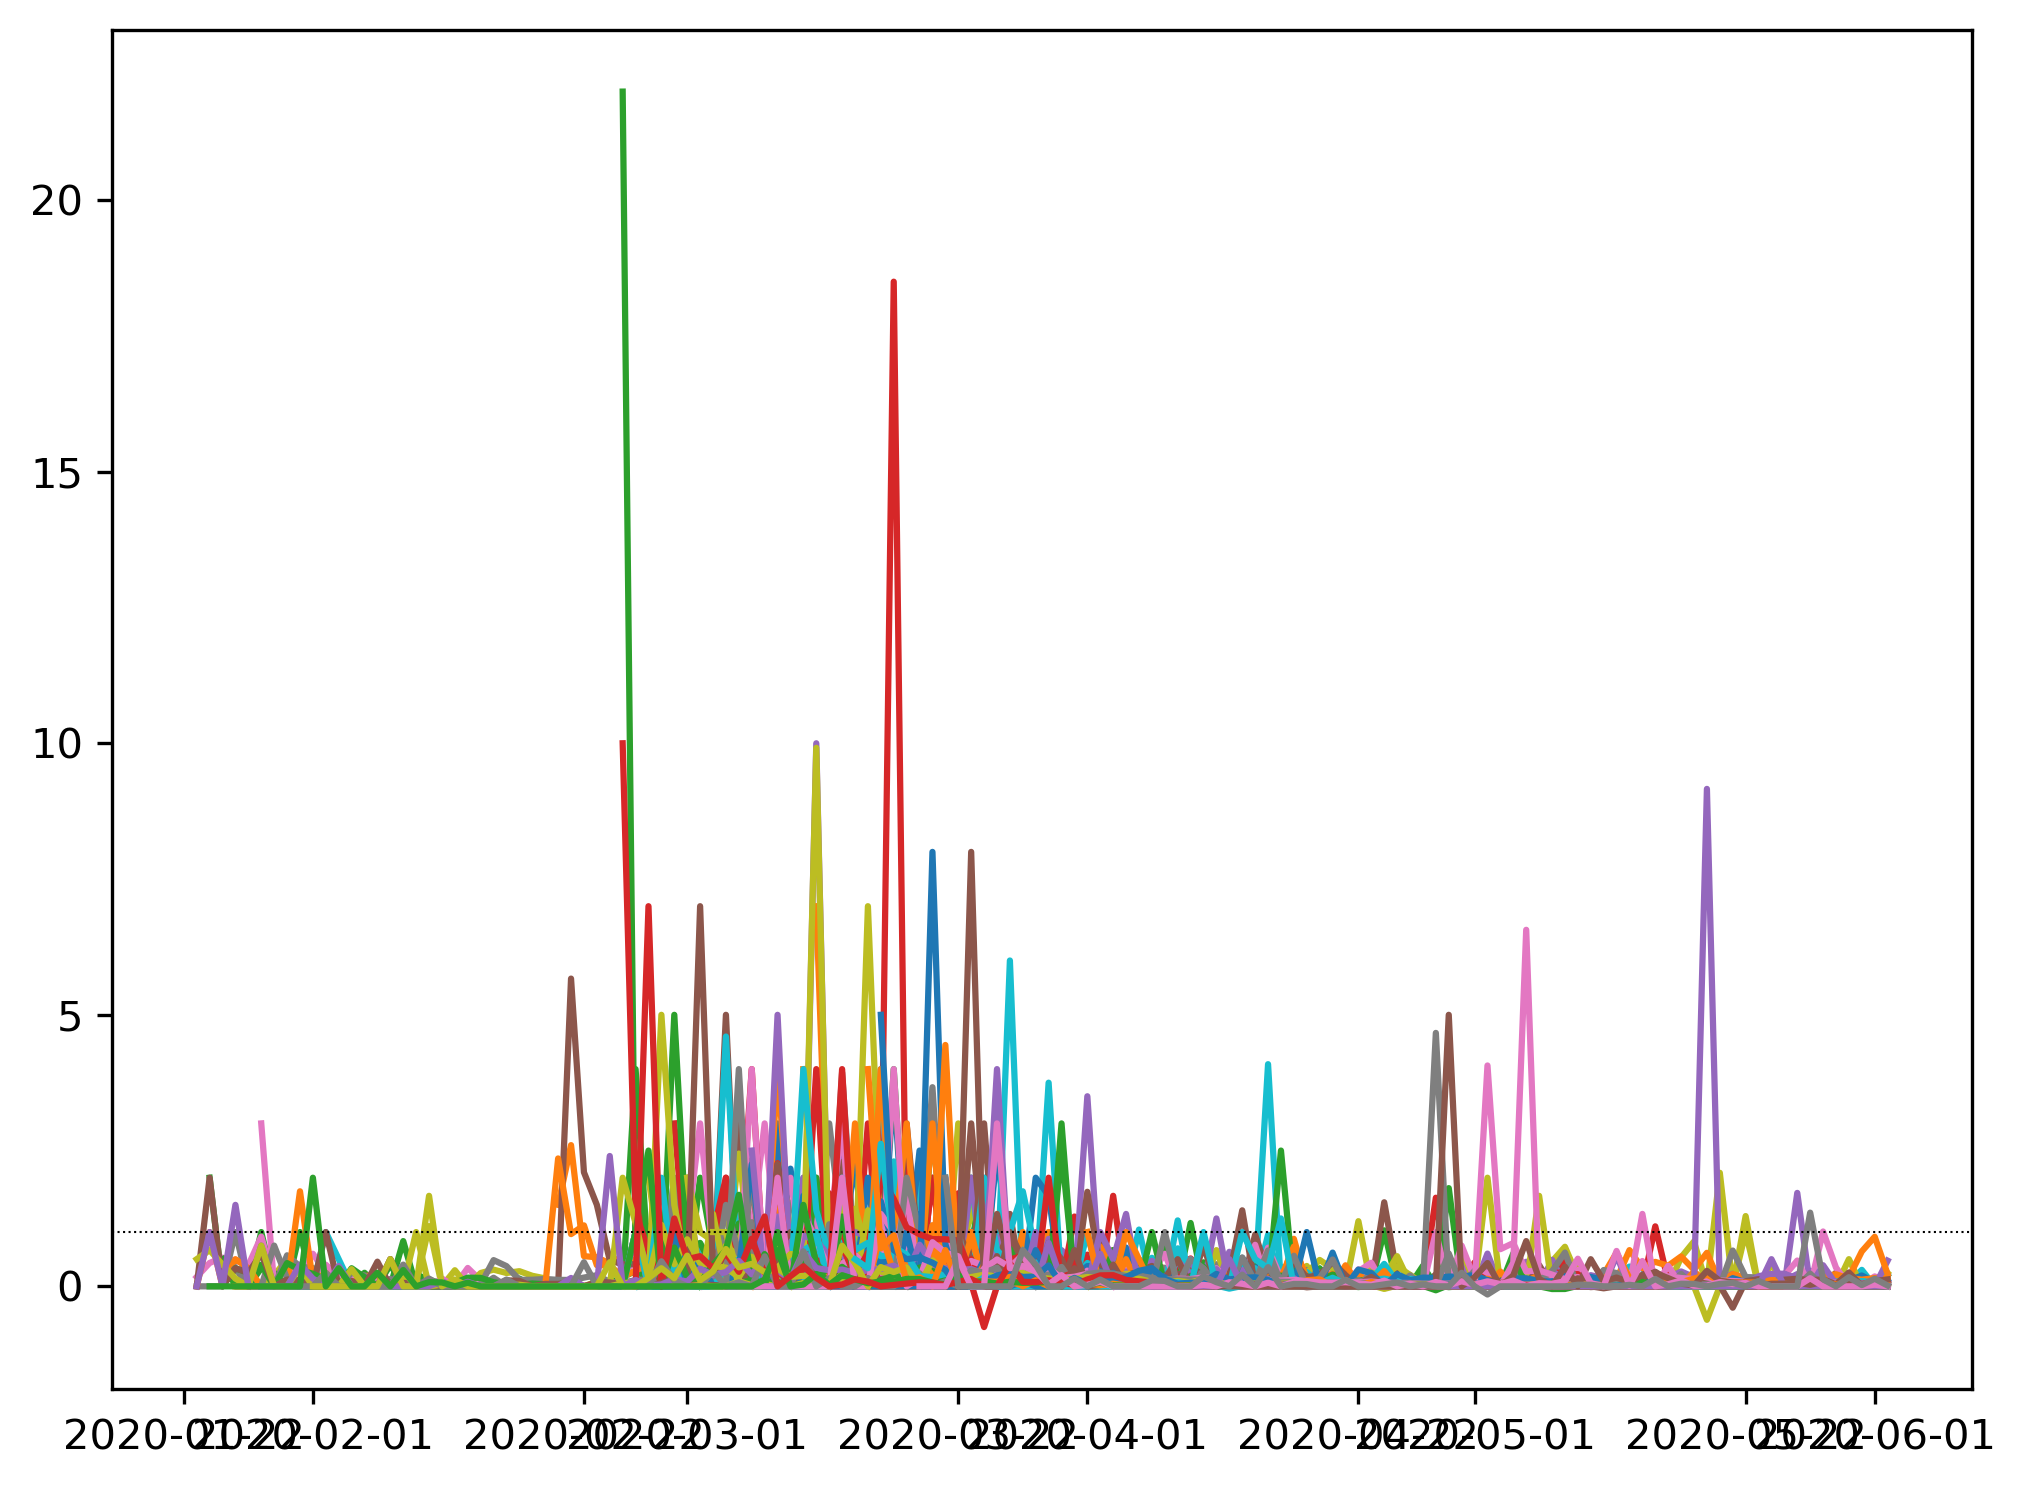

In [34]:
pct_fig, pct_ax = plt.subplots(figsize=(8,6), dpi=300)
pct_ax.plot(df_by_country.pct_change())
pct_ax.axhline(y=1, color="black", linestyle=":", linewidth=".5")

The key observation from the above graph is that percentage changes above 100% are usually an artifact of low case numbers, and cases before this time (at least) should be filtered out.

In [35]:
df_by_country.pct_change() > 1

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22            False    False    False    False   False   
2020-01-23            False    False    False    False   False   
2020-01-24            False    False    False    False   False   
2020-01-25            False    False    False    False   False   
2020-01-26            False    False    False    False   False   
...                     ...      ...      ...      ...     ...   
2020-05-29            False    False    False    False   False   
2020-05-30            False    False    False    False   False   
2020-05-31            False    False    False    False   False   
2020-06-01            False    False    False    False   False   
2020-06-02            False    False    False    False   False   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                    False      False    False      False    False   
2020-01-23                    False      False    False      False    False   
2020-01-24                    False      False    False      False    False   
2020-01-25                    False      False    False      False    False   
2020-01-26                    False      False    False       True    False   
...                             ...        ...      ...        ...      ...   
2020-05-29                    False      False    False      False    False   
2020-05-30                    False      False    False      False    False   
2020-05-31                    False      False    False      False    False   
2020-06-01                    False      False    False      False    False   
2020-06-02                    False      False    False      False    False   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...           False    False       False      False    False   
2020-01-23      ...           False    False       False      False     True   
2020-01-24      ...           False    False       False      False    False   
2020-01-25      ...           False    False       False      False    False   
2020-01-26      ...           False    False       False      False    False   
...             ...             ...      ...         ...        ...      ...   
2020-05-29      ...           False    False       False      False    False   
2020-05-30      ...           False    False       False      False    False   
2020-05-31      ...           False    False       False      False    False   
2020-06-01      ...           False    False       False      False    False   
2020-06-02      ...           False    False       False      False    False   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                   False           False  False   False     False  
2020-01-23                   False           False  False   False     False  
2020-01-24                   False           False  False   False     False  
2020-01-25                   False           False  False   False     False  
2020-01-26                   False           False  False   False     False  
...                            ...             ...    ...     ...       ...  
2020-05-29                   False           False  False   False     False  
2020-05-30                   False           False  False   False     False  
2020-05-31                   False           False  False   False     False  
2020-06-01                   False           False  False   False     False  
2020-06-02                   False           False  False   False     False  

[133 rows x 188 columns]

In [36]:
df_by_country[df_by_country.pct_change() > 1]

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22              NaN      NaN      NaN      NaN     NaN   
2020-01-23              NaN      NaN      NaN      NaN     NaN   
2020-01-24              NaN      NaN      NaN      NaN     NaN   
2020-01-25              NaN      NaN      NaN      NaN     NaN   
2020-01-26              NaN      NaN      NaN      NaN     NaN   
...                     ...      ...      ...      ...     ...   
2020-05-29              NaN      NaN      NaN      NaN     NaN   
2020-05-30              NaN      NaN      NaN      NaN     NaN   
2020-05-31              NaN      NaN      NaN      NaN     NaN   
2020-06-01              NaN      NaN      NaN      NaN     NaN   
2020-06-02              NaN      NaN      NaN      NaN     NaN   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                      NaN        NaN      NaN        NaN      NaN   
2020-01-23                      NaN        NaN      NaN        NaN      NaN   
2020-01-24                      NaN        NaN      NaN        NaN      NaN   
2020-01-25                      NaN        NaN      NaN        NaN      NaN   
2020-01-26                      NaN        NaN      NaN        4.0      NaN   
...                             ...        ...      ...        ...      ...   
2020-05-29                      NaN        NaN      NaN        NaN      NaN   
2020-05-30                      NaN        NaN      NaN        NaN      NaN   
2020-05-31                      NaN        NaN      NaN        NaN      NaN   
2020-06-01                      NaN        NaN      NaN        NaN      NaN   
2020-06-02                      NaN        NaN      NaN        NaN      NaN   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...             NaN      NaN         NaN        NaN      NaN   
2020-01-23      ...             NaN      NaN         NaN        NaN      2.0   
2020-01-24      ...             NaN      NaN         NaN        NaN      NaN   
2020-01-25      ...             NaN      NaN         NaN        NaN      NaN   
2020-01-26      ...             NaN      NaN         NaN        NaN      NaN   
...             ...             ...      ...         ...        ...      ...   
2020-05-29      ...             NaN      NaN         NaN        NaN      NaN   
2020-05-30      ...             NaN      NaN         NaN        NaN      NaN   
2020-05-31      ...             NaN      NaN         NaN        NaN      NaN   
2020-06-01      ...             NaN      NaN         NaN        NaN      NaN   
2020-06-02      ...             NaN      NaN         NaN        NaN      NaN   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                     NaN             NaN    NaN     NaN       NaN  
2020-01-23                     NaN             NaN    NaN     NaN       NaN  
2020-01-24                     NaN             NaN    NaN     NaN       NaN  
2020-01-25                     NaN             NaN    NaN     NaN       NaN  
2020-01-26                     NaN             NaN    NaN     NaN       NaN  
...                            ...             ...    ...     ...       ...  
2020-05-29                     NaN             NaN    NaN     NaN       NaN  
2020-05-30                     NaN             NaN    NaN     NaN       NaN  
2020-05-31                     NaN             NaN    NaN     NaN       NaN  
2020-06-01                     NaN             NaN    NaN     NaN       NaN  
2020-06-02                     NaN             NaN    NaN     NaN       NaN  

[133 rows x 188 columns]

In [37]:
df_by_country['Sweden'][df_by_country['Sweden'].pct_change() > 1].index[-1]

datetime.date(2020, 3, 5)

In [38]:
def get_last_date_crossed(series, threshold):
    try:
        result = series[series.pct_change() > threshold].index[-1]
        return result
    except IndexError:
        return np.nan

In [39]:
def get_last_date_crossed_1(series):
    return get_last_date_crossed(series, 1)

In [40]:
dates_last_crossed_1 = df_by_country.apply(func=get_last_date_crossed_1).dropna()
dates_last_crossed_1

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-10
Algeria               2020-03-04
Andorra               2020-03-17
Angola                2020-03-20
                         ...    
West Bank and Gaza    2020-03-07
Western Sahara        2020-04-05
Yemen                 2020-04-29
Zambia                2020-03-25
Zimbabwe              2020-05-27
Length: 185, dtype: object

According to this result, as of currently run period, 3 countries ($185 - 182 = 3$) have not crossed 100% increase in cases yet.

Next, we take a look at which countries this may be.

In [41]:
set(df_by_country.columns) - set(dates_last_crossed_1.index)

{'China', 'Japan', 'Thailand'}

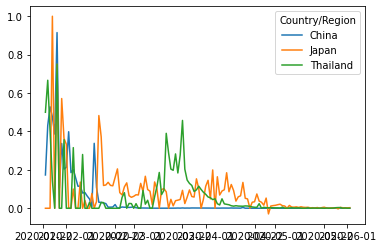

In [42]:
df_by_country[set(df_by_country.columns) - set(dates_last_crossed_1.index)].pct_change().plot()

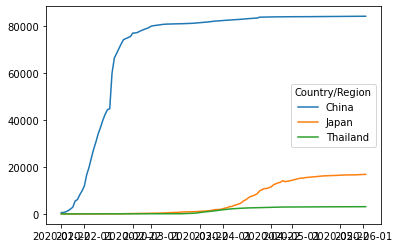

In [43]:
df_by_country[set(df_by_country.columns) - set(dates_last_crossed_1.index)].plot()

This suggests a problem with the function, since these three countries have had cases, but have never crossed 100% increases in case count throughout their history. This suggests that the threshold should be lowered.

In [44]:
df_by_country['Thailand'].pct_change().max()

0.75

In [45]:
def get_last_date_crossed_07499(series):
    return get_last_date_crossed(series, .7499)

In [46]:
dates_last_crossed_07499 = df_by_country.apply(func=get_last_date_crossed_07499).dropna()
dates_last_crossed_07499

Country/Region
Afghanistan           2020-03-24
Albania               2020-03-12
Algeria               2020-03-04
Andorra               2020-03-17
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-07
Western Sahara        2020-04-05
Yemen                 2020-05-05
Zambia                2020-03-25
Zimbabwe              2020-05-27
Length: 188, dtype: object

In [47]:
df_by_country['Afghanistan'][dt.date(2020, 3, 8)]

4

In [48]:
for i in dates_last_crossed_07499.index:
    print(f"Country: {i}, Date: {dates_last_crossed_07499[i]}, Case Count: {df_by_country[i][dates_last_crossed_07499[i]]}")

Country: Afghanistan, Date: 2020-03-24, Case Count: 74
Country: Albania, Date: 2020-03-12, Case Count: 23
Country: Algeria, Date: 2020-03-04, Case Count: 12
Country: Andorra, Date: 2020-03-17, Case Count: 39
Country: Angola, Date: 2020-03-21, Case Count: 2
Country: Antigua and Barbuda, Date: 2020-03-26, Case Count: 7
Country: Argentina, Date: 2020-03-07, Case Count: 8
Country: Armenia, Date: 2020-03-16, Case Count: 52
Country: Australia, Date: 2020-01-26, Case Count: 4
Country: Austria, Date: 2020-02-29, Case Count: 9
Country: Azerbaijan, Date: 2020-03-05, Case Count: 6
Country: Bahamas, Date: 2020-03-26, Case Count: 9
Country: Bahrain, Date: 2020-03-11, Case Count: 195
Country: Bangladesh, Date: 2020-03-08, Case Count: 3
Country: Barbados, Date: 2020-03-22, Case Count: 14
Country: Belarus, Date: 2020-04-02, Case Count: 304
Country: Belgium, Date: 2020-03-13, Case Count: 559
Country: Belize, Date: 2020-03-25, Case Count: 2
Country: Benin, Date: 2020-03-23, Case Count: 5
Country: Bhutan

In [49]:
last_crossed_07499 = dates_last_crossed_07499.to_frame(name='Date')
last_crossed_07499['Case Count'] = [df_by_country[x][dates_last_crossed_07499[x]] for x in dates_last_crossed_07499.index]
last_crossed_07499

Date  Case Count
Country/Region                            
Afghanistan         2020-03-24          74
Albania             2020-03-12          23
Algeria             2020-03-04          12
Andorra             2020-03-17          39
Angola              2020-03-21           2
...                        ...         ...
West Bank and Gaza  2020-03-07          16
Western Sahara      2020-04-05           4
Yemen               2020-05-05          22
Zambia              2020-03-25          12
Zimbabwe            2020-05-27         132

[188 rows x 2 columns]

In [50]:
last_crossed_07499.describe()

Case Count
count    188.000000
mean     356.031915
std     2020.410764
min        2.000000
25%        8.000000
50%       22.000000
75%       83.000000
max    22719.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b911f7250>]],
      dtype=object)

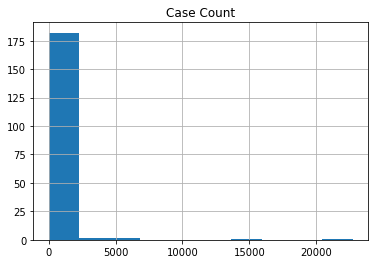

In [51]:
last_crossed_07499.hist()

In [52]:
last_crossed_07499.sort_values(by='Case Count')

Date  Case Count
Country/Region                                
Bosnia and Herzegovina  2020-03-05           2
Lesotho                 2020-05-22           2
Angola                  2020-03-21           2
Fiji                    2020-03-22           2
Mauritania              2020-03-19           2
...                            ...         ...
Germany                 2020-03-13        3675
Spain                   2020-03-13        5232
China                   2020-01-28        5509
US                      2020-03-19       13748
Ecuador                 2020-04-24       22719

[188 rows x 2 columns]

Ecuador has an alarmingly high case count for the most recent 100% change day.

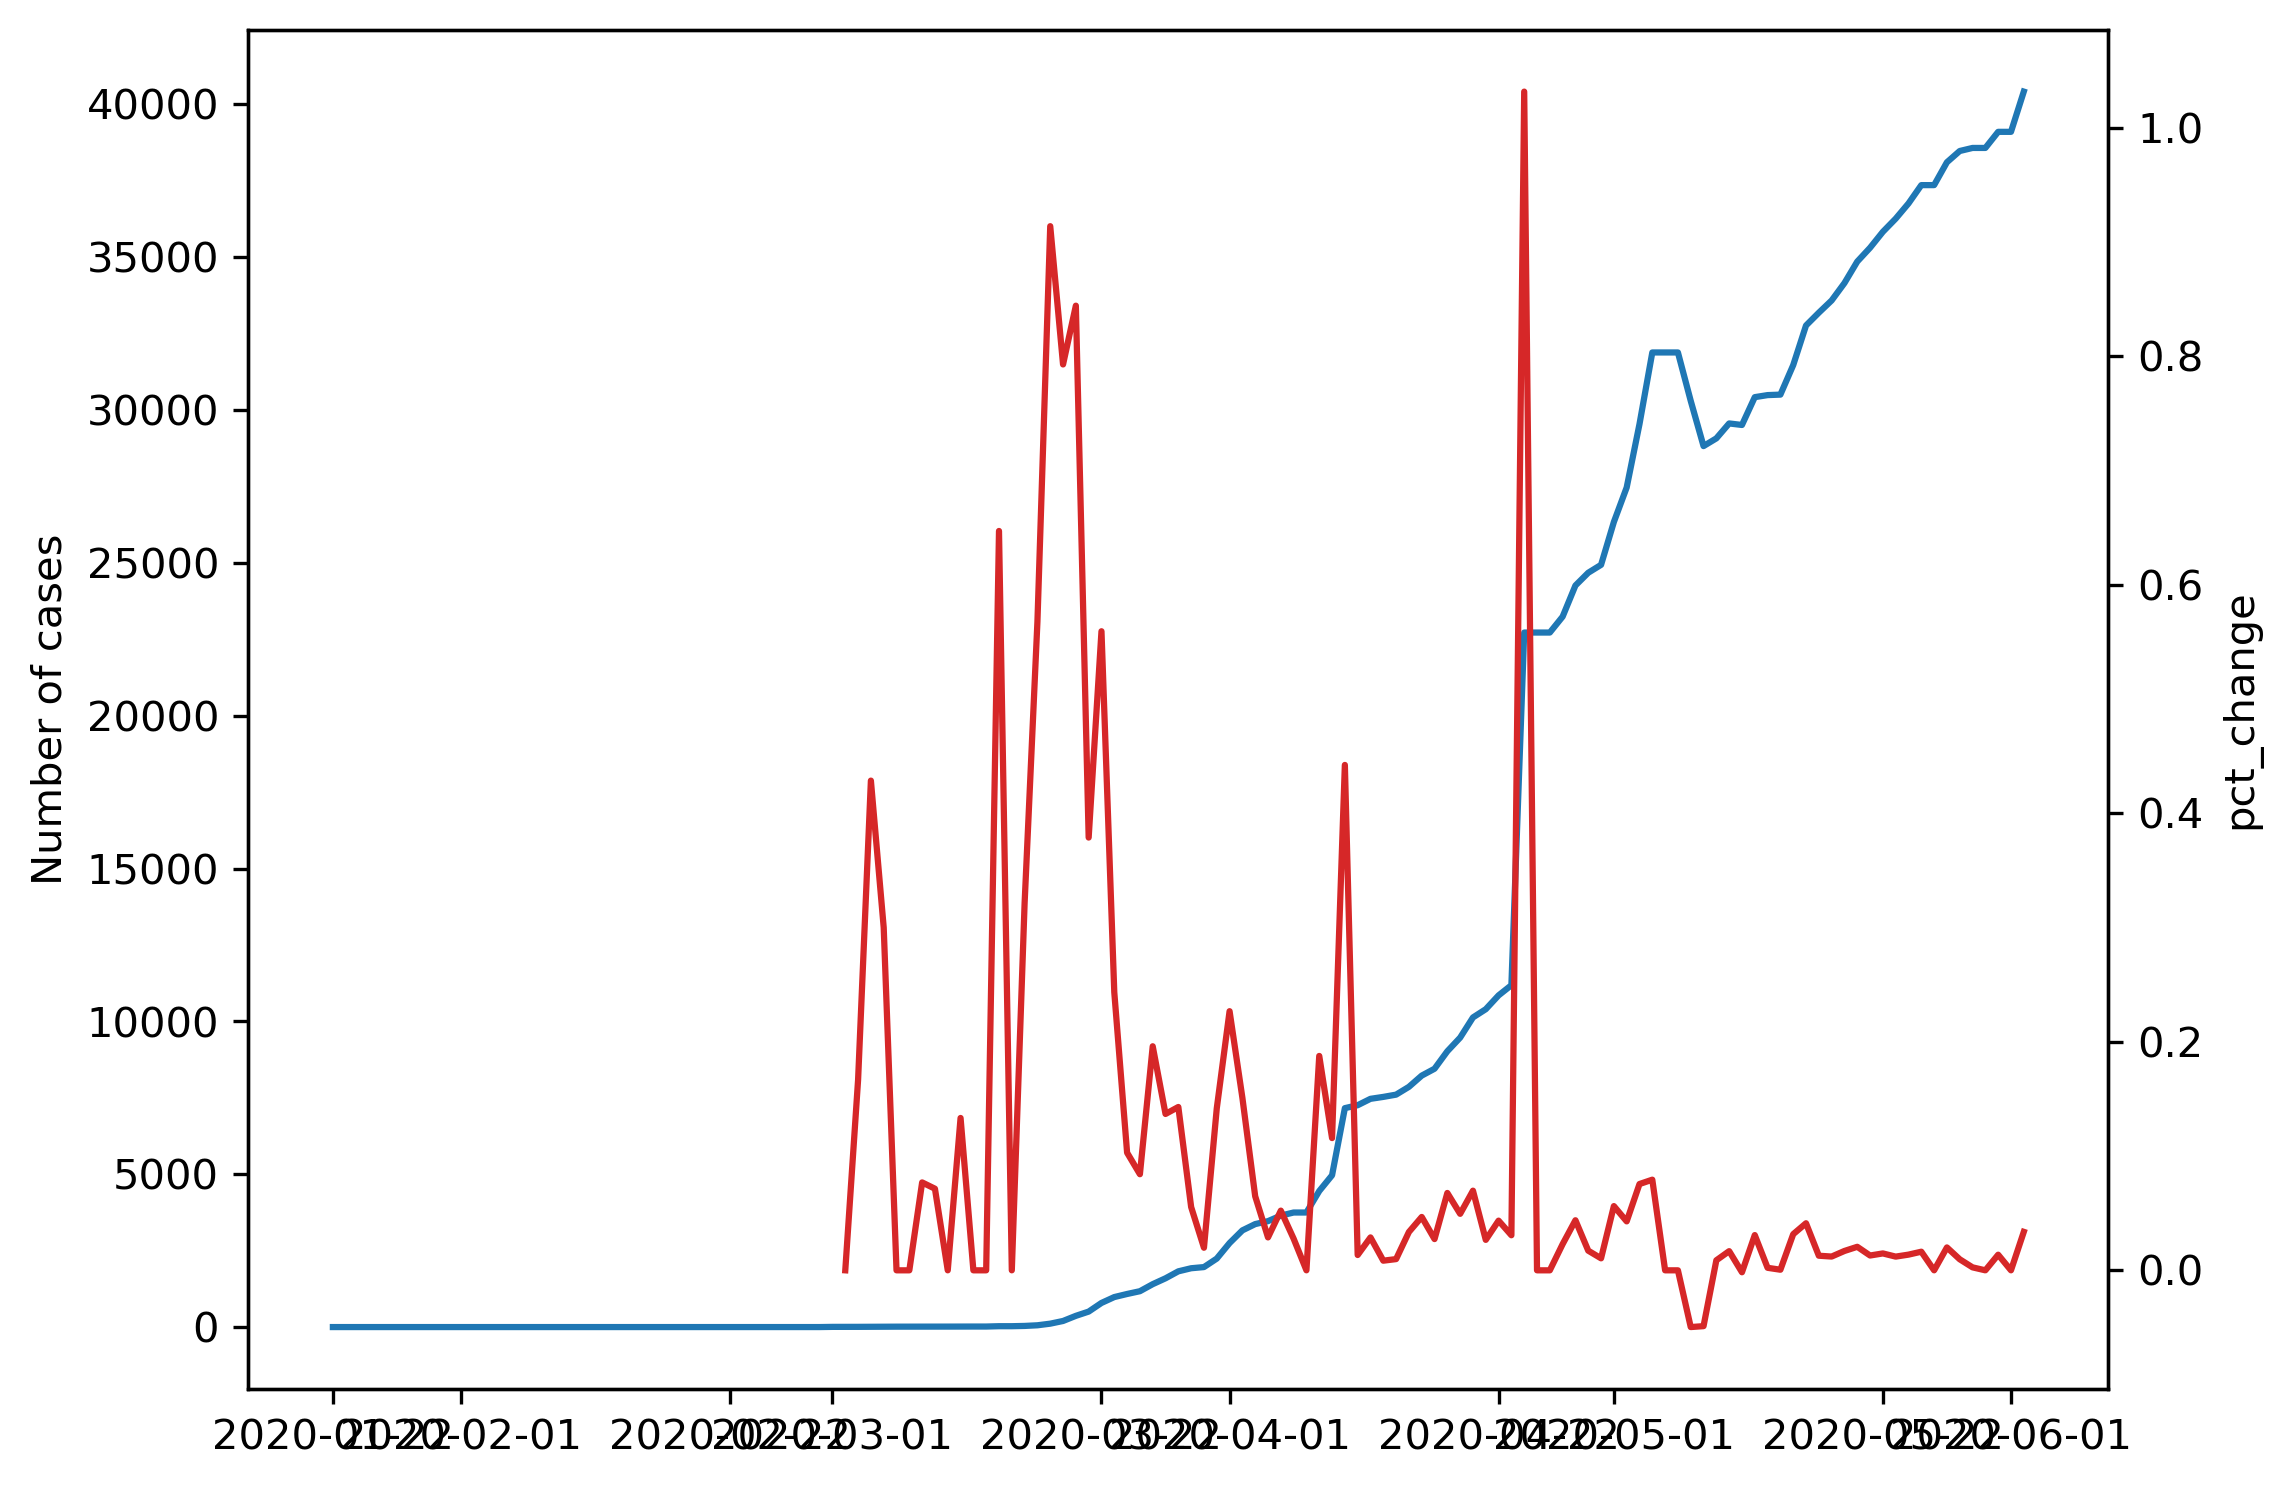

In [53]:
cases_and_rate(df_by_country['Ecuador'])

In [54]:
df_by_country['Ecuador']

2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-05-29    38571
2020-05-30    38571
2020-05-31    39098
2020-06-01    39098
2020-06-02    40414
Name: Ecuador, Length: 133, dtype: int64

Seems to be a counting artifact? The case count changes do not seem very smooth, and almost resemble a "leaky" step function.

In [55]:
last_crossed_07499_series = dates_last_crossed_07499.to_frame(name='Date')
last_crossed_07499_series['Case Count'] = [df_by_country[x][dates_last_crossed_07499[x]:] for x in dates_last_crossed_07499.index]
last_crossed_07499_series

Date  \
Country/Region                   
Afghanistan         2020-03-24   
Albania             2020-03-12   
Algeria             2020-03-04   
Andorra             2020-03-17   
Angola              2020-03-21   
...                        ...   
West Bank and Gaza  2020-03-07   
Western Sahara      2020-04-05   
Yemen               2020-05-05   
Zambia              2020-03-25   
Zimbabwe            2020-05-27   

                                                           Case Count  
Country/Region                                                         
Afghanistan         2020-03-24       74
2020-03-25       84
2020-0...  
Albania             2020-03-12      23
2020-03-13      33
2020-03-...  
Algeria             2020-03-04      12
2020-03-05      12
2020-03-...  
Andorra             2020-03-17     39
2020-03-18     39
2020-03-19...  
Angola              2020-03-21     2
2020-03-22     2
2020-03-23  ...  
...                                                               ...  
West Bank and Gaza  2020-03-07     16
2020-03-08     16
2020-03-09...  
Western Sahara      2020-04-05    4
2020-04-06    4
2020-04-07    ...  
Yemen               2020-05-05     22
2020-05-06     25
2020-05-07...  
Zambia              2020-03-25      12
2020-03-26      16
2020-03-...  
Zimbabwe            2020-05-27    132
2020-05-28    149
2020-05-29...  

[188 rows x 2 columns]

In [56]:
df_by_country['US'][dates_last_crossed_07499['US']:].values

array([  13748,   19274,   25600,   33280,   43862,   53925,   65844,
         83836,  101962,  121786,  140910,  162147,  188172,  213602,
        244008,  275798,  309027,  336802,  366317,  397121,  428654,
        463327,  496846,  526776,  555313,  580624,  607670,  636674,
        667981,  700062,  732590,  758809,  784708,  811865,  840351,
        869170,  905358,  938154,  965785,  988197, 1012582, 1039909,
       1069424, 1103461, 1132539, 1158040, 1180375, 1204351, 1229331,
       1257023, 1283929, 1309550, 1329260, 1347881, 1369376, 1390406,
       1417774, 1442824, 1467820, 1486757, 1508308, 1528568, 1551853,
       1577147, 1600937, 1622612, 1643246, 1662302, 1680913, 1699176,
       1721753, 1746019, 1770165, 1790172, 1811020, 1831821])

In [57]:
{x:df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index}

{'Afghanistan': array([   74,    84,    94,   110,   110,   120,   170,   174,   237,
          273,   281,   299,   349,   367,   423,   444,   484,   521,
          555,   607,   665,   714,   784,   840,   906,   933,   996,
         1026,  1092,  1176,  1279,  1351,  1463,  1531,  1703,  1828,
         1939,  2171,  2335,  2469,  2704,  2894,  3224,  3392,  3563,
         3778,  4033,  4402,  4687,  4963,  5226,  5639,  6053,  6402,
         6664,  7072,  7653,  8145,  8676,  9216,  9998, 10582, 11173,
        11831, 12456, 13036, 13659, 14525, 15205, 15750, 16509]),
 'Albania': array([  23,   33,   38,   42,   51,   55,   59,   64,   70,   76,   89,
         104,  123,  146,  174,  186,  197,  212,  223,  243,  259,  277,
         304,  333,  361,  377,  383,  400,  409,  416,  433,  446,  467,
         475,  494,  518,  539,  548,  562,  584,  609,  634,  663,  678,
         712,  726,  736,  750,  766,  773,  782,  789,  795,  803,  820,
         832,  842,  850,  856,  868,  87

In [58]:
len([df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index])

188

In [59]:
cases_after_cross_07499 = pd.DataFrame(data=[df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index],
                                   #columns=dates_last_crossed_07499.index
                                  )
cases_after_cross_07499 = cases_after_cross_07499.transpose()
cases_after_cross_07499.columns=[x for x in dates_last_crossed_07499.index]
cases_after_cross_07499

Afghanistan  Albania  Algeria  Andorra  Angola  Antigua and Barbuda  \
0           74.0     23.0     12.0     39.0     2.0                  7.0   
1           84.0     33.0     12.0     39.0     2.0                  7.0   
2           94.0     38.0     17.0     53.0     3.0                  7.0   
3          110.0     42.0     17.0     75.0     3.0                  7.0   
4          110.0     51.0     19.0     88.0     3.0                  7.0   
..           ...      ...      ...      ...     ...                  ...   
126          NaN      NaN      NaN      NaN     NaN                  NaN   
127          NaN      NaN      NaN      NaN     NaN                  NaN   
128          NaN      NaN      NaN      NaN     NaN                  NaN   
129          NaN      NaN      NaN      NaN     NaN                  NaN   
130          NaN      NaN      NaN      NaN     NaN                  NaN   

     Argentina  Armenia  Australia  Austria  ...  United Kingdom  Uruguay  \
0          8.0     52.0        4.0      9.0  ...             8.0     29.0   
1         12.0     78.0        5.0     14.0  ...             8.0     50.0   
2         12.0     84.0        5.0     18.0  ...             9.0     79.0   
3         17.0    115.0        6.0     21.0  ...             9.0     94.0   
4         19.0    136.0        9.0     29.0  ...             9.0    110.0   
..         ...      ...        ...      ...  ...             ...      ...   
126        NaN      NaN     7202.0      NaN  ...             NaN      NaN   
127        NaN      NaN     7221.0      NaN  ...             NaN      NaN   
128        NaN      NaN     7229.0      NaN  ...             NaN      NaN   
129        NaN      NaN        NaN      NaN  ...             NaN      NaN   
130        NaN      NaN        NaN      NaN  ...             NaN      NaN   

     Uzbekistan  Venezuela  Vietnam  West Bank and Gaza  Western Sahara  \
0           6.0       33.0      6.0                16.0             4.0   
1          10.0       36.0      6.0                16.0             4.0   
2          15.0       42.0      8.0                19.0             4.0   
3          23.0       42.0      8.0                26.0             4.0   
4          33.0       70.0      8.0                30.0             4.0   
..          ...        ...      ...                 ...             ...   
126         NaN        NaN      NaN                 NaN             NaN   
127         NaN        NaN      NaN                 NaN             NaN   
128         NaN        NaN      NaN                 NaN             NaN   
129         NaN        NaN      NaN                 NaN             NaN   
130         NaN        NaN      NaN                 NaN             NaN   

     Yemen  Zambia  Zimbabwe  
0     22.0    12.0     132.0  
1     25.0    16.0     149.0  
2     25.0    22.0     149.0  
3     34.0    28.0     174.0  
4     34.0    29.0     178.0  
..     ...     ...       ...  
126    NaN     NaN       NaN  
127    NaN     NaN       NaN  
128    NaN     NaN       NaN  
129    NaN     NaN       NaN  
130    NaN     NaN       NaN  

[131 rows x 188 columns]

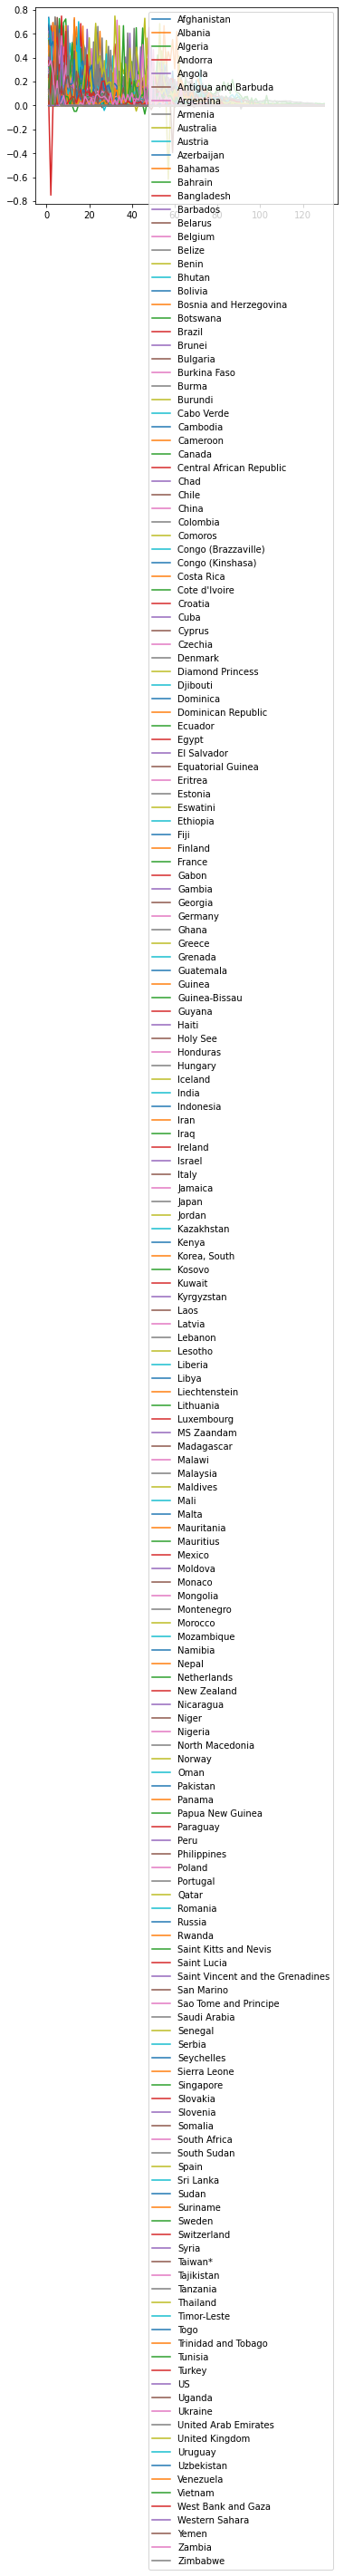

In [60]:
cases_after_cross_07499.pct_change().plot()

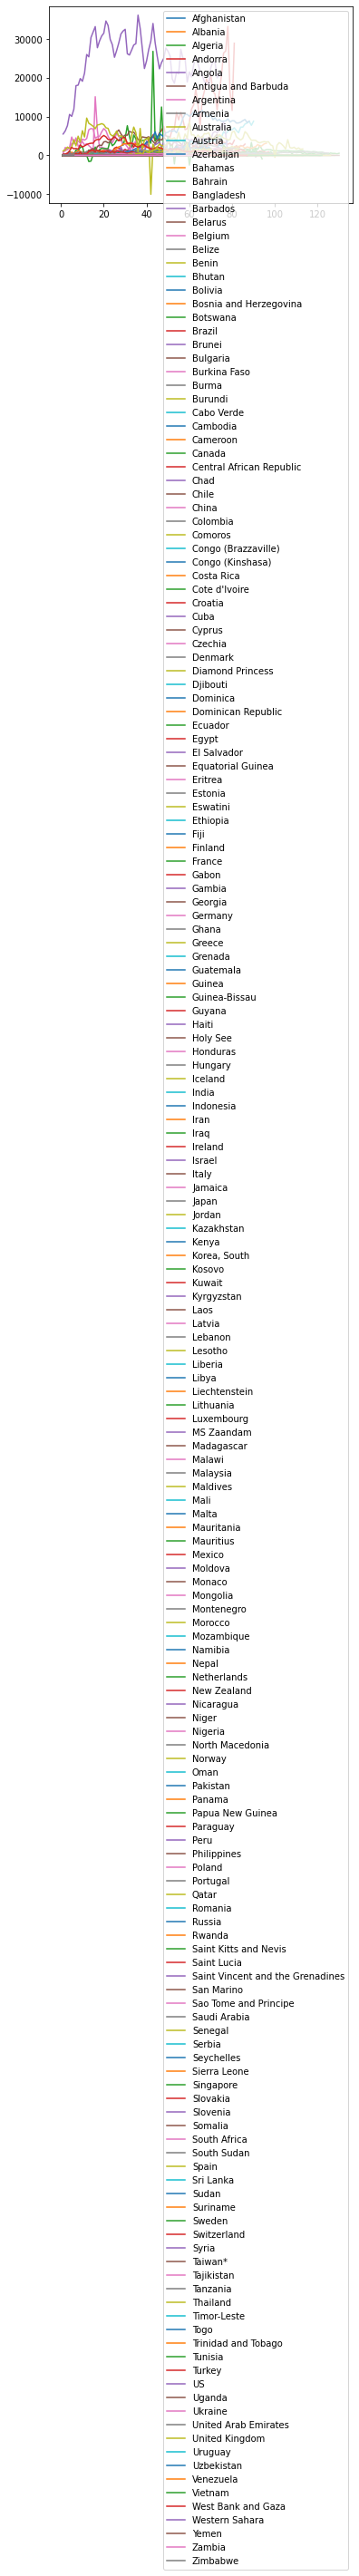

In [61]:
cases_after_cross_07499.diff().plot()

In [62]:
cases_after_cross_07499.dropna(axis=1)

Singapore  Taiwan*
0          3.0      3.0
1          3.0      3.0
2          4.0      4.0
3          5.0      5.0
4          7.0      8.0
..         ...      ...
126    33860.0    442.0
127    34366.0    442.0
128    34884.0    442.0
129    35292.0    443.0
130    35836.0    443.0

[131 rows x 2 columns]

In [63]:
cases_after_cross_07499[cases_after_cross_07499.pct_change() < 0].dropna(axis=1)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[131 rows x 0 columns]

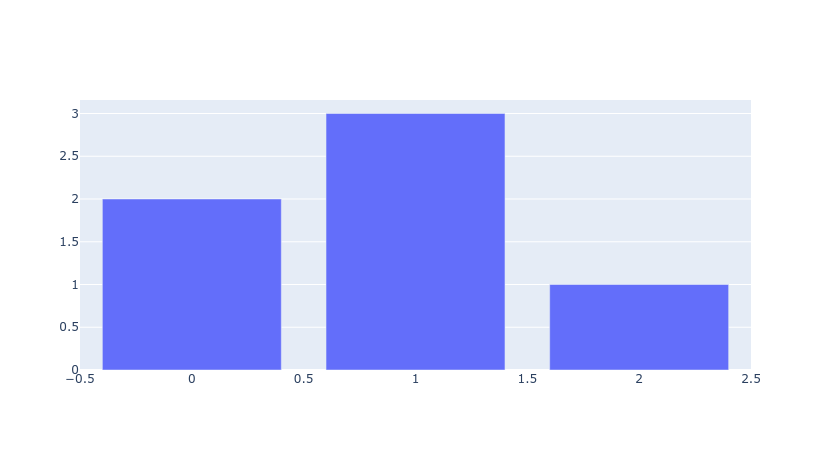

In [64]:
# sample plotly figure from quickstart
ptlyfig = go.Figure(data=go.Bar(y=[2, 3, 1]))
ptlyfig.show()

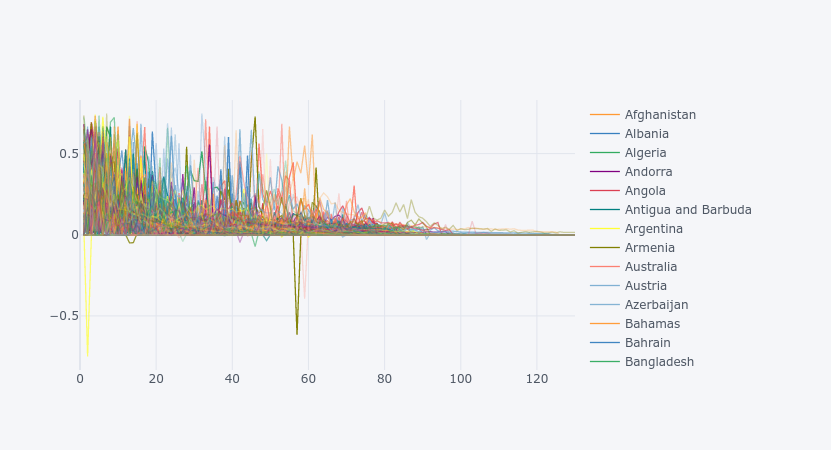

In [65]:
# using .figure() instead of .iplot(), otherwise the following error is obtained:
# PlotlyRequestError: Authentication credentials were not provided.
cases_after_cross_07499.pct_change().figure()

In [66]:
cases_after_cross_07499['Guyana']

0      19.0
1      20.0
2       5.0
3       5.0
4       5.0
       ... 
126     NaN
127     NaN
128     NaN
129     NaN
130     NaN
Name: Guyana, Length: 131, dtype: float64

## Code snippets

In [67]:
def process_JHU():
    
    dfs = {}
    
    # First, retrieve data
    for x in ['confirmed','deaths','recovered']:
        dfs[x + '_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL[upper(x)])
                           .rename(columns=_process_columns)
                          )
    
    for x in ['confirmed','deaths']:
        dfs[x + '_US_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_' + upper(x)])
                              .rename(columns={'Long_': 'Long',
                                               'Country_Region': 'Country/Region',
                                               'Province_State': 'Province/State'
                                              })
                              .rename(columns=_process_columns)
                             )
        dfs[x + '_GLOBAL'] = _concatenate_US() # concatenate both US and global data
        dfs[x + '_COUNTRY'] = _country_level(dfs[x + '_GLOBAL']) # Generate country-level data
    
    def _country_level(df):
        '''Generate country-level dataframe of numbers from concatenated dataframes.
        '''
        temp_df = df.drop(['Lat', 'Long', 'Province/State'])
        temp_df = pd.pivot_table(temp_df,
                                 index=['Country/Region'],
                                 aggfunc=np.sum
                                )
        return temp_df
    
    def _concatenate_US(global_df, us_df):
        '''Concatenate both dataframes to return country-level information.
        Discards data more granular than the province/state level.
        '''
        temp_df = us_df.copy()
        excess_cols = set(us_df.columns) - set(global_df.columns)
        temp_df = temp_df.drop(excess_cols)
        return temp_df
    
    def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            return col_name

In [68]:
[_process_columns(x) for x in df_confirmed.columns[4:]]

[datetime.date(2020, 1, 22),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 4),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 6),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 8),
 datetime.date(2020, 2, 9),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 12),
 datetime.date(2020, 2, 13),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 16),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 2, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 2, 22),
 datetime.date(2020, 2, 23),
 datetime.date(2020, 2, 24),
 datetime.date(2020, 2,

## Population information

In [82]:
worldbank_pop_request = requests.get(WORLDBANK_POP_ZIP)
with zf.ZipFile(io.BytesIO(worldbank_pop_request.content), 'r') as wb_pop_zip:
    wb_pop_zip.extractall('tmp')

In [83]:
# to replace if possible
#POPULATION_CSV = "API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"
#COUNTRY_METADATA_CSV = "Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"

In [84]:
population_csvs = [x for x in os.listdir('tmp') if x.startswith("API_SP")]
file_dates = {}
for file in population_csvs:
    with open('tmp/' + file) as csvfile:
        reader = csv.reader(csvfile)
        for row in itertools.islice(reader, 2, 3):
            file_dates[file] = dt.datetime.strptime(row[1], "%Y-%m-%d").date()
POPULATION_CSV = max(file_dates)

In [102]:
df_worldbank_pop = pd.read_csv("tmp/" + POPULATION_CSV, skiprows=3, index_col="Country Name").iloc[:, :-2]
#df_country_metadata = pd.read_csv("tmp/" + COUNTRY_METADATA_CSV)

In [183]:
def retrieve_worldbank(wb_code):
    raw_csvs = [x for x in os.listdir('tmp') if x.startswith("API_" + wb_code)]
    file_dates = {}
    for file in raw_csvs:
        with open('tmp/' + file) as csvfile:
            reader = csv.reader(csvfile)
            for row in itertools.islice(reader, 2, 3):
                file_dates[file] = dt.datetime.strptime(row[1], "%Y-%m-%d").date()
    return pd.read_csv("tmp/" + max(file_dates), skiprows=3, index_col="Country Name").iloc[:, :-2]

def latest_worldbank(wb_code):
    return retrieve_worldbank(wb_code).iloc[:, [0, -1]]

In [103]:
df_worldbank_pop

Country Code     Indicator Name Indicator Code        1960  \
Country Name                                                              
Aruba                 ABW  Population, total    SP.POP.TOTL     54211.0   
Afghanistan           AFG  Population, total    SP.POP.TOTL   8996973.0   
Angola                AGO  Population, total    SP.POP.TOTL   5454933.0   
Albania               ALB  Population, total    SP.POP.TOTL   1608800.0   
Andorra               AND  Population, total    SP.POP.TOTL     13411.0   
...                   ...                ...            ...         ...   
Kosovo                XKX  Population, total    SP.POP.TOTL    947000.0   
Yemen, Rep.           YEM  Population, total    SP.POP.TOTL   5315355.0   
South Africa          ZAF  Population, total    SP.POP.TOTL  17099840.0   
Zambia                ZMB  Population, total    SP.POP.TOTL   3070776.0   
Zimbabwe              ZWE  Population, total    SP.POP.TOTL   3776681.0   

                    1961        1962        1963        1964        1965  \
Country Name                                                               
Aruba            55438.0     56225.0     56695.0     57032.0     57360.0   
Afghanistan    9169410.0   9351441.0   9543205.0   9744781.0   9956320.0   
Angola         5531472.0   5608539.0   5679458.0   5735044.0   5770570.0   
Albania        1659800.0   1711319.0   1762621.0   1814135.0   1864791.0   
Andorra          14375.0     15370.0     16412.0     17469.0     18549.0   
...                  ...         ...         ...         ...         ...   
Kosovo          966000.0    994000.0   1022000.0   1050000.0   1078000.0   
Yemen, Rep.    5393036.0   5473671.0   5556766.0   5641597.0   5727751.0   
South Africa  17524533.0  17965725.0  18423161.0  18896307.0  19384841.0   
Zambia         3164329.0   3260650.0   3360104.0   3463213.0   3570464.0   
Zimbabwe       3905034.0   4039201.0   4178726.0   4322861.0   4471177.0   

                    1966  ...        2009        2010        2011        2012  \
Country Name              ...                                                   
Aruba            57715.0  ...    101455.0    101669.0    102046.0    102560.0   
Afghanistan   10174836.0  ...  28394813.0  29185507.0  30117413.0  31161376.0   
Angola         5781214.0  ...  22514281.0  23356246.0  24220661.0  25107931.0   
Albania        1914573.0  ...   2927519.0   2913021.0   2905195.0   2900401.0   
Andorra          19647.0  ...     84463.0     84449.0     83747.0     82427.0   
...                  ...  ...         ...         ...         ...         ...   
Kosovo         1106000.0  ...   1761474.0   1775680.0   1791000.0   1805200.0   
Yemen, Rep.    5816247.0  ...  22516460.0  23154855.0  23807588.0  24473178.0   
South Africa  19888250.0  ...  50477011.0  51216964.0  52004172.0  52834005.0   
Zambia         3681955.0  ...  13215139.0  13605984.0  14023193.0  14465121.0   
Zimbabwe       4623351.0  ...  12526968.0  12697723.0  12894316.0  13115131.0   

                    2013        2014        2015        2016        2017  \
Country Name                                                               
Aruba           103159.0    103774.0    104341.0    104872.0    105366.0   
Afghanistan   32269589.0  33370794.0  34413603.0  35383128.0  36296400.0   
Angola        26015780.0  26941779.0  27884381.0  28842484.0  29816748.0   
Albania        2895092.0   2889104.0   2880703.0   2876101.0   2873457.0   
Andorra          80774.0     79213.0     78011.0     77297.0     77001.0   
...                  ...         ...         ...         ...         ...   
Kosovo         1824100.0   1821800.0   1801800.0   1816200.0   1830700.0   
Yemen, Rep.   25147109.0  25823485.0  26497889.0  27168210.0  27834821.0   
South Africa  53689236.0  54545991.0  55386367.0  56203654.0  57000451.0   
Zambia        14926504.0  15399753.0  15879361.0  16363507.0  16853688.0   
Zimbabwe      13350356.0  13586681.0  13814629.0  14030390.0  14236745.0   

     

In [105]:
latest_worldbank_pop = df_worldbank_pop.iloc[:, [0, -1]]
latest_worldbank_pop

Country Code        2018
Country Name                         
Aruba                 ABW    105845.0
Afghanistan           AFG  37172386.0
Angola                AGO  30809762.0
Albania               ALB   2866376.0
Andorra               AND     77006.0
...                   ...         ...
Kosovo                XKX   1845300.0
Yemen, Rep.           YEM  28498687.0
South Africa          ZAF  57779622.0
Zambia                ZMB  17351822.0
Zimbabwe              ZWE  14439018.0

[264 rows x 2 columns]

In [109]:
latest_worldbank_pop.loc['Aruba'].iloc[-1]

105845.0

Unfortunately, the country list for the two datasets do not correspond one-to-one.

In [117]:
set(df_by_country.columns) - set(latest_worldbank_pop.index)

{'Bahamas',
 'Brunei',
 'Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Czechia',
 'Diamond Princess',
 'Egypt',
 'Gambia',
 'Holy See',
 'Iran',
 'Korea, South',
 'Kyrgyzstan',
 'Laos',
 'MS Zaandam',
 'Russia',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Slovakia',
 'Syria',
 'Taiwan*',
 'US',
 'Venezuela',
 'Western Sahara',
 'Yemen'}

We can see for a start, that two cruise vessels are included in the dataset, and should ideally be removed.

In [118]:
set(latest_worldbank_pop.index) - set(df_by_country.columns)

{'American Samoa',
 'Arab World',
 'Aruba',
 'Bahamas, The',
 'Bermuda',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Caribbean small states',
 'Cayman Islands',
 'Central Europe and the Baltics',
 'Channel Islands',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Curacao',
 'Czech Republic',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'Egypt, Arab Rep.',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Faroe Islands',
 'Fragile and conflict affected situations',
 'French Polynesia',
 'Gambia, The',
 'Gibraltar',
 'Greenland',
 'Guam',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'Hong Kong SAR, China',
 'IBRD only',
 'IDA & IBRD total',
 'IDA blend',
 'IDA only',
 'IDA total',
 'Iran, Islamic Rep.',
 'Isle of Man',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 

In [131]:
{x:difflib.get_close_matches(x, latest_worldbank_pop.index, n=5, cutoff=0.3) for x in (set(df_by_country.columns) - set(latest_worldbank_pop.index))}

{'Saint Kitts and Nevis': ['St. Kitts and Nevis',
  'St. Vincent and the Grenadines',
  'Cayman Islands',
  'Solomon Islands',
  'Channel Islands'],
 'Diamond Princess': ['Sao Tome and Principe',
  'Middle income',
  'San Marino',
  'Low income',
  'Timor-Leste'],
 'Congo (Kinshasa)': ['Mongolia',
  'Hong Kong SAR, China',
  'Congo, Rep.',
  'Colombia',
  'Solomon Islands'],
 'Korea, South': ['Korea, Rep.',
  'South Asia',
  'South Sudan',
  'Korea, Dem. People’s Rep.',
  'Micronesia, Fed. Sts.'],
 'MS Zaandam': ['New Zealand', 'Sri Lanka', 'Uganda', 'Rwanda', 'Panama'],
 'Russia': ['Tunisia',
  'Austria',
  'Australia',
  'South Asia',
  'Russian Federation'],
 'Egypt': ['Egypt, Arab Rep.', 'Cyprus', 'Uruguay', 'Hungary', 'Estonia'],
 'Venezuela': ['Venezuela, RB',
  'Vietnam',
  'Senegal',
  'Guatemala',
  'Greenland'],
 'US': [],
 'Syria': ['Serbia', 'Suriname', 'Sri Lanka', 'Somalia', 'Nigeria'],
 'Kyrgyzstan': ['Kazakhstan',
  'Uzbekistan',
  'Kyrgyz Republic',
  'Afghanistan',
  

In [134]:
[x for x in filter(lambda x: x.startswith('U'), latest_worldbank_pop.index)]

['United Arab Emirates',
 'United Kingdom',
 'Uganda',
 'Ukraine',
 'Upper middle income',
 'Uruguay',
 'United States',
 'Uzbekistan']

In [136]:
[x for x in filter(lambda x: x.startswith('S'), latest_worldbank_pop.index)]

['Switzerland',
 'Spain',
 'St. Kitts and Nevis',
 'St. Lucia',
 'Sri Lanka',
 'St. Martin (French part)',
 'South Asia',
 'Saudi Arabia',
 'Sudan',
 'Senegal',
 'Singapore',
 'Solomon Islands',
 'Sierra Leone',
 'San Marino',
 'Somalia',
 'Serbia',
 'Sub-Saharan Africa (excluding high income)',
 'South Sudan',
 'Sub-Saharan Africa',
 'Small states',
 'Sao Tome and Principe',
 'Suriname',
 'Slovak Republic',
 'Slovenia',
 'Sweden',
 'Sint Maarten (Dutch part)',
 'Seychelles',
 'Syrian Arab Republic',
 'South Asia (IDA & IBRD)',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'St. Vincent and the Grenadines',
 'Samoa',
 'South Africa']

In [140]:
worldbank_countries = {
    'Saint Kitts and Nevis': 'St. Kitts and Nevis',
    'Diamond Princess': '',
    'Congo (Kinshasa)': 'Congo, Dem. Rep.',
    'Korea, South': 'Korea, Rep.',
    'MS Zaandam': '',
    'Russia': 'Russian Federation',
    'Egypt': 'Egypt, Arab Rep.',
    'Venezuela': 'Venezuela, RB',
    'US': 'United States',
    'Syria': 'Syrian Arab Republic',
    'Kyrgyzstan': 'Kyrgyz Republic',
    'Yemen': 'Yemen, Rep.',
    'Gambia': 'Gambia, The',
    'Holy See': '',
    'Slovakia': 'Slovak Republic',
    'Laos': 'Lao PDR',
    'Congo (Brazzaville)': 'Congo, Rep.',
    'Czechia': 'Czech Republic',
    'Iran': 'Iran, Islamic Rep.',
    'Western Sahara': '',
    'Saint Lucia': 'St. Lucia',
    'Bahamas': 'Bahamas, The',
    'Taiwan*': '', # https://datahelpdesk.worldbank.org/knowledgebase/topics/19280-country-classification
    'Burma': 'Myanmar',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    'Brunei': 'Brunei Darussalam'
}

In [112]:
def calculate_case_rate(cases, population):
    result = cases.copy()
    for col in cases.columns:
        result[col] = 1000000 * cases[col]/population.loc[col].iloc[-1] # calculate cases per million
        
    return result

In [174]:
cases_per_capita = calculate_case_rate(df_by_country.drop(columns=[key for (key, value) in worldbank_countries.items() if value == '']),
                                       latest_worldbank_pop.rename(index={v:k for (k,v) in worldbank_countries.items()})
                                      )
cases_per_capita

Country/Region  Afghanistan     Albania     Algeria       Andorra    Angola  \
2020-01-22         0.000000    0.000000    0.000000      0.000000  0.000000   
2020-01-23         0.000000    0.000000    0.000000      0.000000  0.000000   
2020-01-24         0.000000    0.000000    0.000000      0.000000  0.000000   
2020-01-25         0.000000    0.000000    0.000000      0.000000  0.000000   
2020-01-26         0.000000    0.000000    0.000000      0.000000  0.000000   
...                     ...         ...         ...           ...       ...   
2020-05-29       367.450182  383.410969  216.299782   9921.304833  2.629037   
2020-05-30       390.747045  391.435039  219.449319   9921.304833  2.726409   
2020-05-31       409.040195  396.668127  222.456772   9921.304833  2.791323   
2020-06-01       423.701615  398.761363  225.274779   9934.290834  2.791323   
2020-06-02       444.119998  406.087687  227.950701  10960.184921  2.791323   

Country/Region  Antigua and Barbuda   Argentina      Armenia   Australia  \
2020-01-22                 0.000000    0.000000     0.000000    0.000000   
2020-01-23                 0.000000    0.000000     0.000000    0.000000   
2020-01-24                 0.000000    0.000000     0.000000    0.000000   
2020-01-25                 0.000000    0.000000     0.000000    0.000000   
2020-01-26                 0.000000    0.000000     0.000000    0.160111   
...                             ...         ...          ...         ...   
2020-05-29               259.643146  346.537197  2939.247423  287.559129   
2020-05-30               259.643146  364.404573  3024.280975  287.879351   
2020-05-31               270.028872  378.720948  3144.547554  288.279628   
2020-06-01               270.028872  391.396672  3215.691164  289.040155   
2020-06-02               270.028872  411.713789  3390.839955  289.360376   

Country/Region      Austria  ...  United Arab Emirates  United Kingdom  \
2020-01-22         0.000000  ...              0.000000        0.000000   
2020-01-23         0.000000  ...              0.000000        0.000000   
2020-01-24         0.000000  ...              0.000000        0.000000   
2020-01-25         0.000000  ...              0.000000        0.000000   
2020-01-26         0.000000  ...              0.000000        0.000000   
...                     ...  ...                   ...             ...   
2020-05-29      1883.938741  ...           3444.101465     4101.799413   
2020-05-30      1887.332206  ...           3519.483366     4126.054478   
2020-05-31      1892.535519  ...           3588.116199     4155.199678   
2020-06-01      1892.761750  ...           3654.049405     4178.973254   
2020-06-02      1895.702753  ...           3715.933169     4203.890368   

Country/Region     Uruguay  Uzbekistan  Venezuela   Vietnam  \
2020-01-22        0.000000    0.000000   0.000000  0.000000   
2020-01-23        0.000000    0.000000   0.000000  0.020934   
2020-01-24        0.000000    0.000000   0.000000  0.020934   
2020-01-25        0.000000    0.000000   0.000000  0.020934   
2020-01-26        0.000000    0.000000   0.000000  0.020934   
...                    ...         ...        ...       ...   
2020-05-29      236.569807  105.233133  47.453784  3.433103   
2020-05-30      238.019377  107.599968  50.536548  3.433103   
2020-05-31      238.599205  109.936460  52.303076  3.433103   
2020-06-01      239.179033  112.333639  57.568021  3.433103   
2020-06-02      239.468947  114.093593  63.006156  3.433103   

Country/Region  West Bank and Gaza      Yemen     Zambia   Zimbabwe  
2020-01-22                0.000000   0.000000   0.000000   0.000000  
2020-01-23                0.000000   0.000000   0.000000   0.000000  
2020-01-24                0.000000   0.000000   0.000000   0.000000  
2020-01-25                0.000000   0.000000   0.000000   0.000000  
2020-01-26                0.000000   0.000000   0.000000   0.000000  
...                            ...        ...        ...        ...  
20

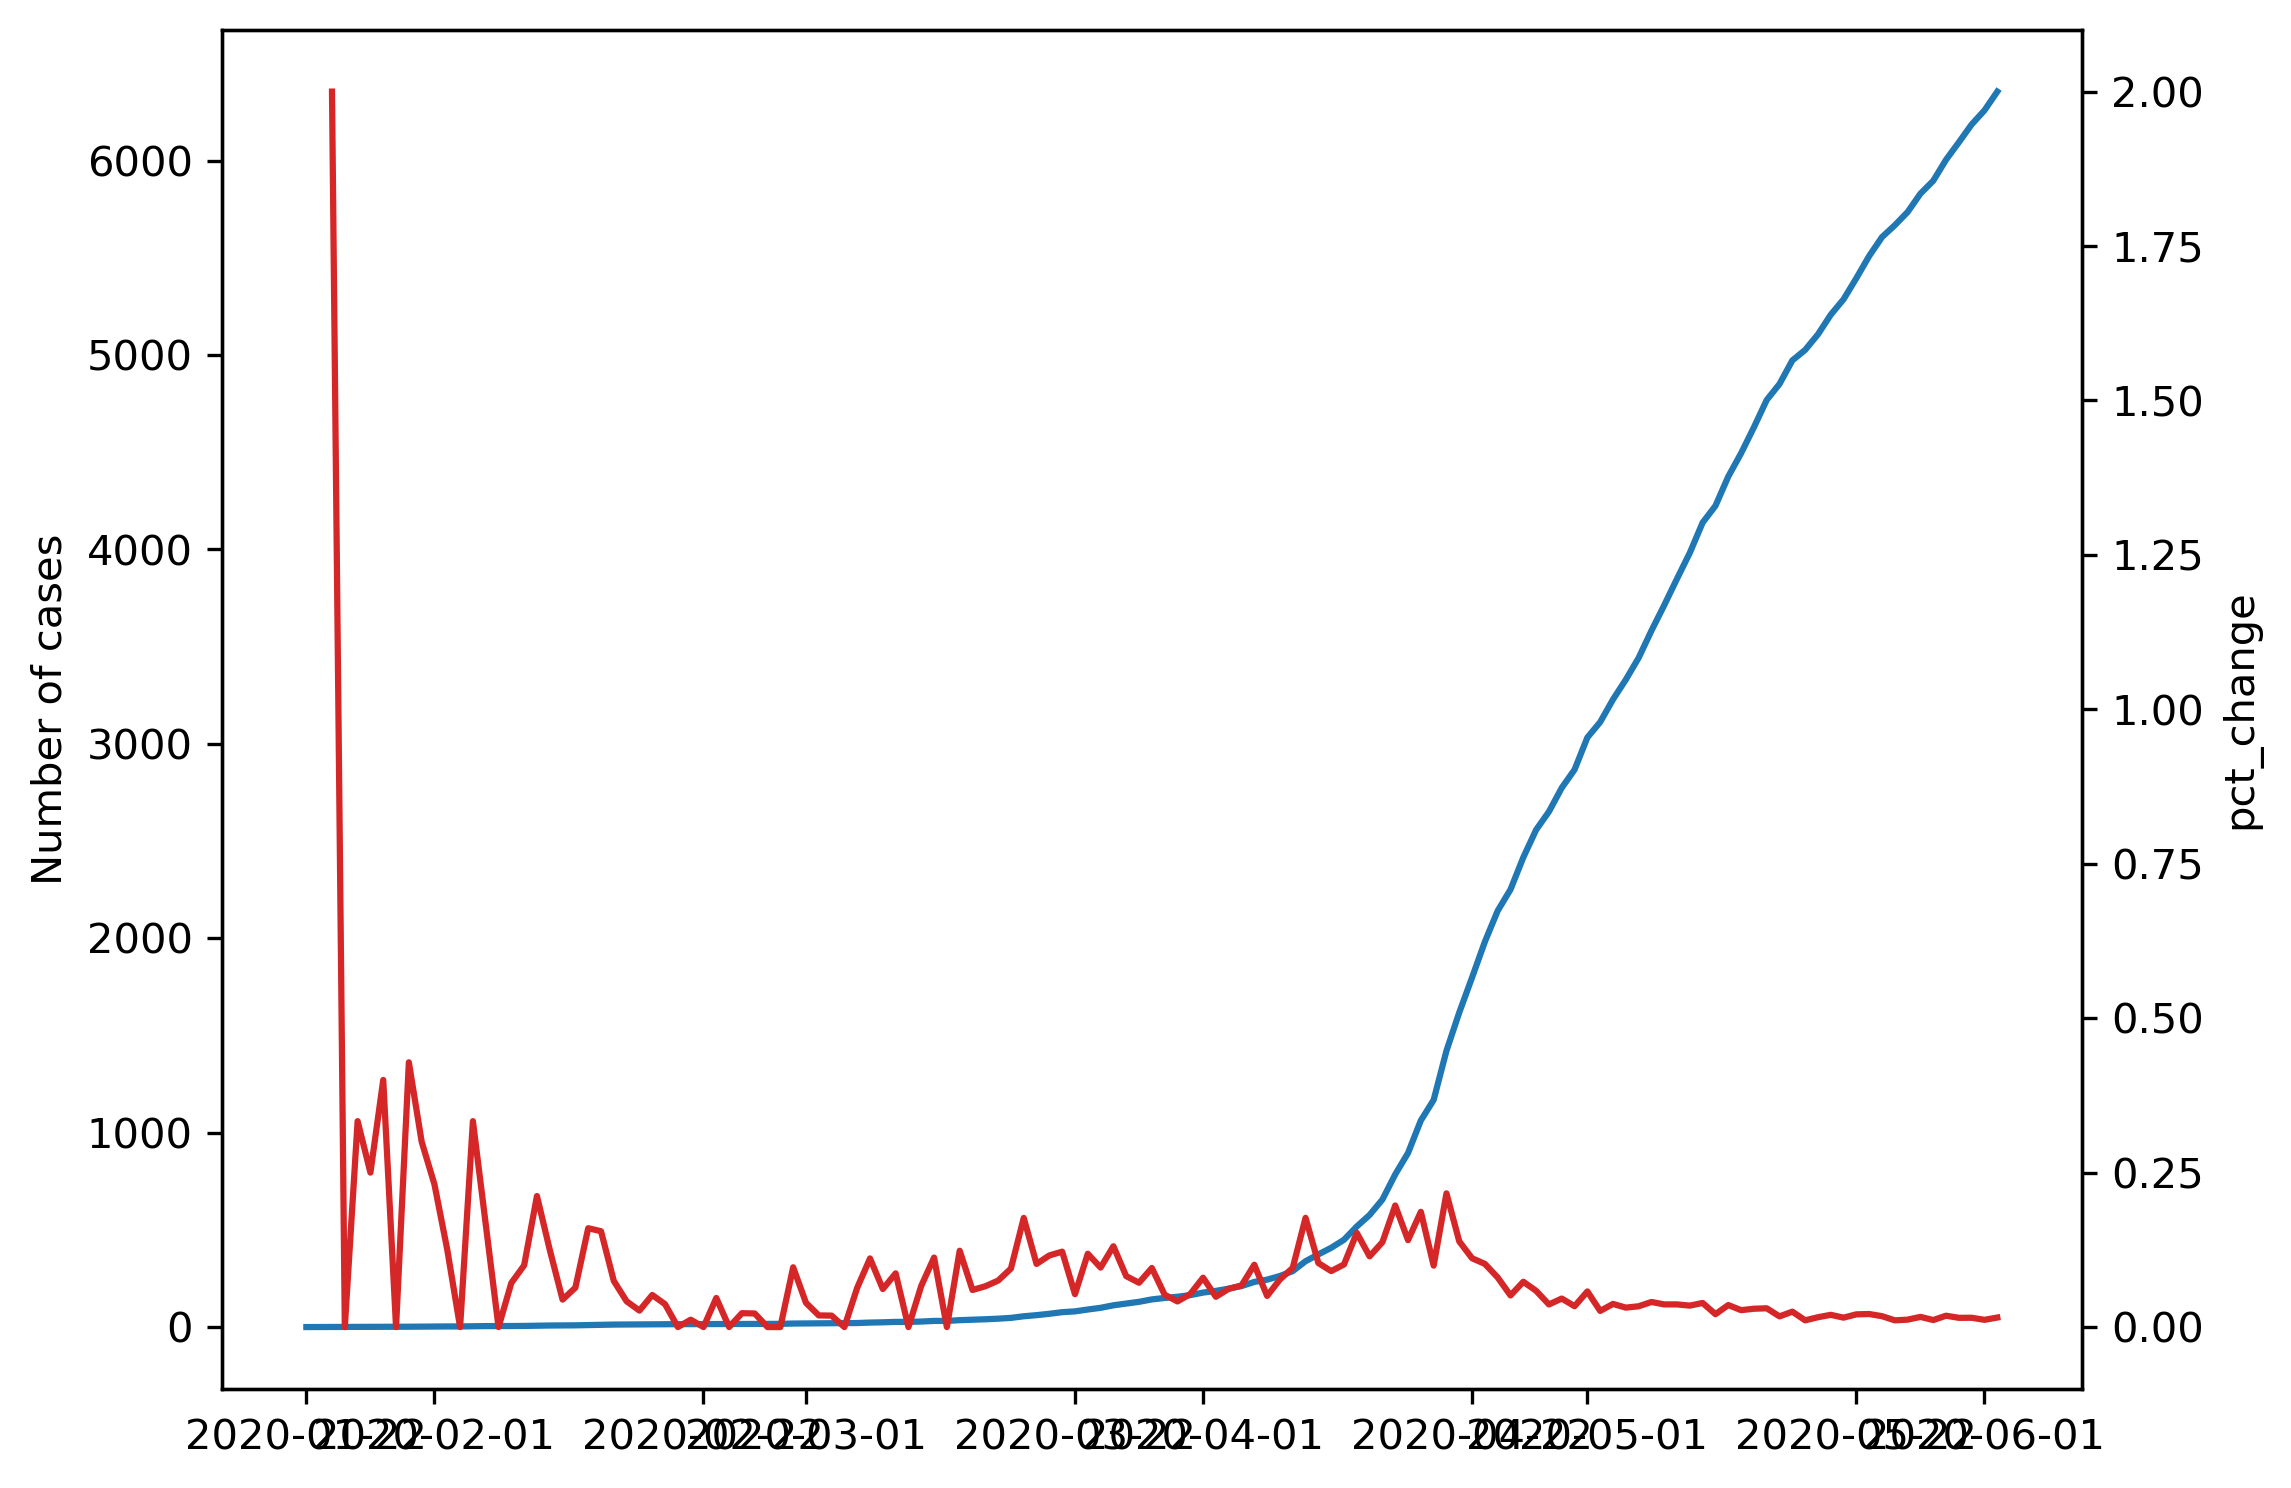

In [173]:
cases_and_rate(cases_per_capita['Singapore'])

# Urban population information

In [176]:
worldbank_urbpop_request = requests.get(WORLDBANK_URB_POP_ZIP)
with zf.ZipFile(io.BytesIO(worldbank_urbpop_request.content), 'r') as wb_urbpop_zip:
    wb_urbpop_zip.extractall('tmp')

In [184]:
df_wb_urban_population = latest_worldbank(WORLDBANK_URBPOP_CODE)

In [185]:
df_wb_urban_population

Country Code    2018
Country Name                     
Aruba                 ABW  43.411
Afghanistan           AFG  25.495
Angola                AGO  65.514
Albania               ALB  60.319
Andorra               AND  88.062
...                   ...     ...
Kosovo                XKX     NaN
Yemen, Rep.           YEM  36.642
South Africa          ZAF  66.355
Zambia                ZMB  43.521
Zimbabwe              ZWE  32.209

[264 rows x 2 columns]

In [193]:
df_wb_urban_population[df_wb_urban_population.iloc[:, -1].isna()]

Country Code  2018
Country Name                               
Eritrea                           ERI   NaN
Not classified                    INX   NaN
St. Martin (French part)          MAF   NaN
Kosovo                            XKX   NaN

Data does not appear to be available for 4 countries.

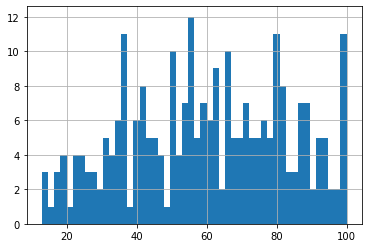

In [200]:
df_wb_urban_population.iloc[:, -1].hist(bins=50)